# Description
This code implements 1D Dilated convolutional DenseNet for machine learning on time-series with domain adversarial regularization.The dilated convolutions were used inspired by the WaveNet architecture [2]. The implementation follows the findings of the original paper on DenseNets [1] with some small differences.

* Each convolution block is a composite operation with "1x1" 1D convolution (A better term would be "filter-wise multiplication), BatchNorm, 1D Convolution with kernel size $k$
* Dilated convolutions are used (dilation $d$) in order to have a larger receptive field and facilitate the learning of multi-scale features
* Instead of explicitly concatenating the layers they are kept in a list. The original implementation was in pytorch and some memory efficiency condiderations ([1] section 3.2.1)- it seems TensorFlow is smart enough not to make redundant copies in-memory for the operations.
* Adversarial domain generalization is achieved with the gradient reversal technique described in [2]


## References
[[1]](https://ieeexplore.ieee.org/document/8721151) Convolutional Networks with Dense Connectivity

[[2]](https://arxiv.org/abs/1609.03499) A Generative Model for Raw Audio

[[3]](https://arxiv.org/abs/1505.07818) Domain-Adversarial Training of Neural Networks
## Usage
Three separate json files are used for managing 
* the pre-processing of the data
* the network parametrization
* the training 

Model checkpoints and training/validation losses are saved to disk for subsequent manual inspection for model selection.

### Network structure definition
The network structure is parametrized by a single json file, that contains the input shape, different layer stacks and at least two outputs. One of the inputs should have the property `"id":"timeseries_input"`. This defines the input layer of the time-series. Although the network can produce results for time-series of arbitrary lengths, the length of the time-series during training is required. The input with `"id":"domain_input"` is used for the domain adversarial loss from the $G_d$ classifier and it is also required.




# UNDER CONSTRUCTION! 
* dataset not publicly available
* will be updated with a publicly available dataset


In [1]:
import tensorflow as tf
#tf.enable_eager_execution()
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as pplot
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, Flatten, BatchNormalization, Dropout
from sklearn.decomposition import PCA

import os

#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession
#config = ConfigProto()
#config.gpu_options.allow_growth = True
#sess = InteractiveSession(config=config)
#tf.keras.backend.set_session(sess)
confusion_matrix = tf.math.confusion_matrix
from src.dilated_densenet_adversarial import make_model, make_densenet_parametrization_dictionary

In [2]:
%load_ext autoreload
%autoreload 
#%debug
#from src.dilated_densenet_adversarial import make_model
#from src.dilated_densenet_adversarial import make_densenet_parametrization_dictionary
from src.util import plot_confusion_matrix
from src.experiments_utils import *
#from src.dilated_densenet_adversarial import *

ndn = 5
ndn2 = 5

experiment_parametrization = {
    'dilation_rates_dn1': [2,4,8,16,32,64,128,512,8,16,32,64,128,512],#,4,8,16,32],
    'kernel_sizes_dn1' :  [10] * ndn,#,5,5],
    'nfilters_dn1' :  [20]*ndn,
    'dilation_rates_dn2' : [4]*ndn2,
    'kernel_sizes_dn2' : [5]*ndn2,
    'nfilters_dn2': [10]*ndn2
}

make_network_description_experiments_A(**experiment_parametrization)
model_json = make_network_json_experiments_A(**experiment_parametrization)
#model_json['domain_classifier']['network_layers'][0]['params']['units'] = 500
#model_json['classifier']['network_layers'][0]['params']['units'] = 500


# pred_c = {
#     'network_layers': [
#         {
#             'type': 'Dense',
#             'id': 'prediction',
#             'params': {'units': 10, 'name': 'Y_output'}
#         }
#     ]
# }
# pred_d = {
#     'network_layers': [
#         {
#             'type': 'Dense',
#             'id': 'prediction',
#             'params': {'units': 3, 'name': 'ExpID'}
#         }
#     ]
#}
# model_json['classifier'] = pred_c
# model_json['domain_classifier'] = pred_d
#
model_json["classifier"]["network_layers"][-1]['params']['units'] = 10
model_json["densenet_1d"]["network_layers"][0]["params"]["Variational"] = False
model_json["densenet_1d"]["network_layers"] = [
    model_json["densenet_1d"]["network_layers"][0],model_json["densenet_1d"]["network_layers"][-1]
]
#model_json['domain_classifier']['network_layers'][0]['type'] = 'DenseLocalReparameterization'
#del model_json['domain_classifier']['network_layers'][0]['params']["use_bias"]
#model_json['classifier']['network_layers'][0]['type'] = 'DenseLocalReparameterization'
#del model_json['classifier']['network_layers'][0]['params']['use_bias']
model_json['inputs'][0]['shape'] = (1500,6)


#model.summary()
model_json['domain_classifier']['network_layers'][-1]['params']['units'] = 4;

In [3]:
def plot_dn_output_activation_statistics():
    p1 = inspect_model.predict(Xtrain[::123,:,:], batch_size=50)
    p2 = inspect_model.predict(Xtest[::123,:,:], batch_size=50)
    #pout_test = inspect_model2.predict(Xtest[::123,:,:], batch_size=50)
    pplot.figure(figsize = (20,10))
    
    def plt_stuff(iistart, stuff):
        iistart+=1; pplot.subplot(2,4,iistart)
        pplot.pcolor(np.mean(stuff,1))
        pplot.title('mean - train - sl1')
        iistart+=1; pplot.subplot(2,4,iistart)
        pplot.pcolor(np.std(stuff,1))
        pplot.title('std - train - sl1')
        iistart+=1; pplot.subplot(2,4,iistart)
        pplot.pcolor(np.mean(stuff,0))
        pplot.title("mean - test - sl0")    
        iistart+=1; pplot.subplot(2,4,iistart)
        pplot.pcolor(np.std(stuff,0))
        pplot.title("std - test - sl0")
    plt_stuff(0,p1)
    plt_stuff(4,p2)
    
# plot_dn_output_activation_statistics()

# Data preparation 
Normally there are two more time-consuming pre-processing steps.Namely,
 * The data are first sub-sampled (to 200 cycles every 20000 cycles) and then
 * each cycle is re-sampled to have the same number of points, namely 300 points per cycle.  

In this post-processing stage, a certain ammount of cycles from the end is considered (150k ~ 300k) because any prediction for cycles earlier than that should not work for physical reasons (and since we are having limited experiments). In this final stage of pre-processing unique re-sampled cycles are bundled to *blocks* so that they have more information about the mechanical response of the material. 

In previous attempts prediction was shown to be possible using even a single cycle. With more cycles it is potentially possible to get better accuracy.

In [7]:
from src.util import load_hilti_fatigue_data
#del data
data = load_hilti_fatigue_data(keep_from_end = 100000,leave_exp_out="None",stage_2_from_disk=True, nclasses = 10)
static_normalization = data['normalization']

proc:1
proc:2
proc:3
proc:4


In [8]:
[X_all_0,Y_all_0,Yoh_all_0, eid_vector_all_0] = data['training_instances']

In [9]:
X_all_0.shape

(9169, 1500, 6)

In [10]:
#pplot.figure(figsize = (10,20))
#pplot.plot(X_all_0[:,:,1])
np.any(X_all_0[:,:,1]>0.45,1).shape
Y_all_0.shape

(9169,)

In [11]:
f_more = np.any(X_all_0[:,:,1]>0.35,1)
f_more = np.max((X_all_0[:,:,1]>0.45)*(X_all_0[:,:,1]>0.0),1)

een = eid_vector_all_0 == 'VA_3'
yy = Y_all_0
f_more = f_more * een
ids_1 = np.where((yy>80000)*f_more)[0][1]
ids_2 = np.where((yy<70000)*(yy>30000)*f_more)[0][0]
ids_3 = np.where((yy<5000)*(yy>0)*f_more)[0][0]
ids_1,ids_2, ids_3

(4966, 5282, 6602)

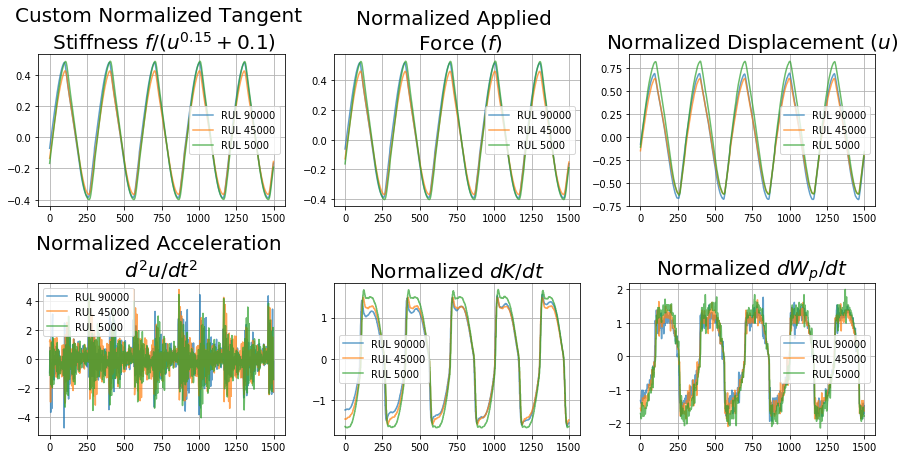

In [16]:
#ax = pplot.figure(figsize = (10,5), dpi = 600)
#fig, axes = pplot.subplots(6, 1, subplot_kw=dict(sharex=True))
fig = pplot.figure(figsize = (15,7) )
ax = fig.subplots(2, 3)
nX = 432
flat_ax = [item for elem in ax for item in elem];

titles = ["Custom Normalized Tangent \n Stiffness $f/(u^{0.15} + 0.1)$ ","Normalized Applied \n Force ($f$)","Normalized Displacement ($u$)",
"Normalized Acceleration \n$d^2u/dt^2$","Normalized $dK/dt$","Normalized $dW_p/dt$"]
def plt_nx(nX):
    for k in [0,1,2,3,4,5]:
        flat_ax[k].plot(X_all_0[nX,:,k], alpha = 0.7)
        flat_ax[k].set_title(titles[k])
        
    
    
#fig.subplots_adjust(wspace = 40)
#     pplot.plot(X_all_0[nX][:,4])


plt_nx(ids_1)
plt_nx(ids_2)
plt_nx(ids_3)
fig.subplots_adjust(hspace = 0.5)

for ax_ in flat_ax:
    ax_.grid()
    ax_.title.set_fontsize(20)
    ax_.legend(["RUL 90000","RUL 45000","RUL 5000"])
#flat_ax[-1]
#pplot.subplots_adjust
fig.savefig("raw_data_plots.pdf")
#pplot.subplots_adjust(wspace = 30)
#pplot.plot(X_all_0[0][:,1])

#pplot.show()
#pplot.plot(X_all_0[654][:,0])
#pplot.plot(X_all_0[654][:,1])
#ax[1].plot([1,2,3])

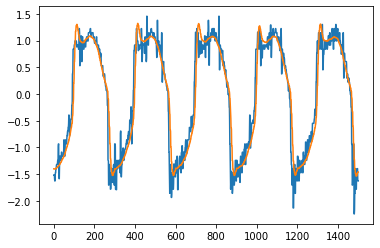

In [12]:
pplot.plot(X_all_0[0][:,5])
pplot.plot(X_all_0[0][:,4])


In [13]:

def col_norm(xx):
    for ii in range(5):
        xx[:,:,ii] = (xx[:,:,ii].T + abs(np.min(xx[:,:,ii],-1))).T
        xx[:,:,ii] = (xx[:,:,ii].T / abs(np.max(xx[:,:,ii],-1))).T
    return xx
#X_all_0 = col_norm(X_all_0)

In [14]:
ids_trainVal = Y_all_0<np.inf
[X_all, Y_all, Yoh_all, eid_vector_all] = [xxx[ids_trainVal] for xxx in  [X_all_0,Y_all_0,Yoh_all_0, eid_vector_all_0]]



In [15]:
#X_all = X_all[:,:,2:]

In [16]:
from ipywidgets import interact, interactive,IntSlider
print("\t Assumption is that since the data presents with a wide range of freq. \n content, different in every channel, we need flow of multi-scale\n information all over the network.")
@interact(idx = IntSlider(min = 0, max = 10000,step = 10))
def aa(idx):
    #pplot.plot(X_all_0[idx][:,0],X_all_0[idx][:,1])
    pplot.figure(figsize = (10,5))
    pplot.subplot(2,1,1)
    pplot.plot(X_all_0[idx][:,3])
    pplot.title("Accelerations")
    pplot.subplot(2,1,2)
    pplot.plot(X_all_0[idx][:,4])
    pplot.title("\"tangent stiffness\"")
    pplot.subplots_adjust(hspace = 1)
    pplot.show()
    

	 Assumption is that since the data presents with a wide range of freq. 
 content, different in every channel, we need flow of multi-scale
 information all over the network.


interactive(children=(IntSlider(value=0, description='idx', max=10000, step=10), Output()), _dom_classes=('wid…

In [17]:
Yoh_all = Yoh_all[:,~np.all(Yoh_all == 0, axis = 0)]

In [18]:
#model_json['domain_classifier']['network_layers'][-1]['params']['units'] = 3


## Other sources of potential bias:
Another source of potential bias in this application is the range of the loading. We don't want the load range to be used for predicting the cycles to failure because there is no causal relation between this and the fatigue RUL. An additional adversarial classifier is created for these unwanted biases too.

In the following the labels are created for that, through some manual thresholding of values.

In [ ]:

# I need a couple of more stuff I need to reg. against
DA2_0 = np.max(X_all_0[:,:,1],-1)
DA3_0 = np.min(X_all_0[:,:,0],-1)
q0 = np.quantile(DA2_0,np.linspace(0,1,400))
q1=np.quantile(DA3_0,np.linspace(0,1,400))
#pplot.plot(q1,'.')
qs0 = [0.25,0.30,0.35,0.40,0.45,0.50]
qs1 = [-0.38,-0.35,-0.32,-0.28]

c0_0 = np.zeros_like(DA2_0);
c1_0 = np.zeros_like(DA3_0);
for qq0 in qs0:
    c0_0 = c0_0 +  (DA2_0<qq0) * 1
    
for qs1 in qs1:
    c1_0 = c1_0 +  (DA3_0<qs1) * 1
c0_0_oh = tf.one_hot(c0_0,np.unique(c0_0).shape[0]).eval()
c1_0_oh = tf.one_hot(c1_0,np.unique(c1_0).shape[0]).eval()


In [22]:
leave_exp_out = 'VA_123'
#model = make_model(model_json)

Yoh_all[np.all(Yoh_all[:,0:10]==0)] = np.ones_like(Yoh_all[np.all(Yoh_all[:,0:10]==0)])
[X,Y,Yoh,eid_vector, coh0, coh1] = [cc[eid_vector_all != leave_exp_out] for cc in [X_all, Y_all, Yoh_all, eid_vector_all, c0_0_oh, c1_0_oh]]
[Xstrong,Ystrong,YstrongOH,eid_vector_strong, c0_oh_strong, c1_oh_strong] = [cc[eid_vector_all == leave_exp_out] for cc in [X_all, Y_all, Yoh_all, eid_vector_all, c0_0_oh, c1_0_oh]]


In [37]:
np.unique(eid_vector), Yoh.shape

(array(['VA_1', 'VA_2', 'VA_3', 'VA_4'], dtype=object), (9169, 10))

# Train/Test split and Training

In [38]:
Y_classes = np.argmax(Yoh,1)
ystrat = Y_classes + (np.argmax(coh0,1)) + (np.argmax(coh1,1))


In [39]:

from sklearn.model_selection import train_test_split

Y_classes = np.argmax(Yoh,1)
EidOH = np.zeros([eid_vector.shape[0],len(np.unique(eid_vector))])
nexperiments = len(np.unique(eid_vector));
for i in np.unique(eid_vector):
    EidOH[eid_vector == i,np.where(np.unique(eid_vector) == i)[0]] = 1

Y_OH = np.zeros([Y.shape[0],len(np.unique(Y_classes))])
for i in np.unique(Y_classes):
    Y_OH[Y_classes == i,np.where(np.unique(Y_classes) == i)[0]] = 1

Y_OH = Y_OH[:,0:10]
Xtrain, Xtest,Ytrain, Ytest,EIDTrain, EIDTest, coh_0_train,coh_0_test , coh_1_train,coh_1_test =train_test_split(
    X, Y_OH, EidOH,coh0,coh1,stratify = ystrat,
    train_size = 0.80, random_state = 645)

#a = model(Xtrain)


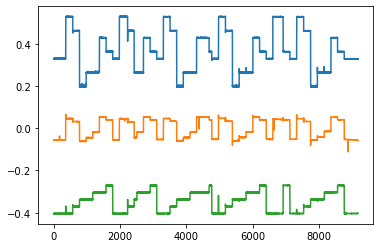

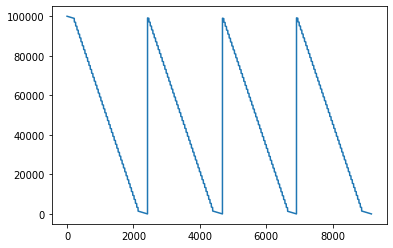

In [17]:
ii = 1;
pplot.plot(np.max(data['training_instances'][0][:,:,ii],1))
pplot.plot(np.mean(data['training_instances'][0][:,:,ii],1))
pplot.plot(np.min(data['training_instances'][0][:,:,ii],1))
pplot.show()
pplot.plot(data['training_instances'][1])

In [19]:
from IPython.display import clear_output
#epoch = 5
c_loss = 50;
def plot_cmatrix_strong_return_top3acc(leave_exp_out, epoch, c_loss,root_folder = "/tmp"):
    yyhat = model.predict(Xstrong)
    cmat = confusion_matrix(np.argmax(YstrongOH,1),np.argmax(yyhat[1],1))
    #cmat = cmat[0:-1,0:-1]
    crange = int(150000/15);
    target_names = ["%i<=Nr<%i"%((i)*crange,(i+1)*crange) for i in range(cmat.shape[0])]
    if epoch % 1 == 0:
        #clear_output()
        plot_confusion_matrix(cmat.eval(session = keras.backend.get_session()),
                              target_names = target_names , figsize = (10,10), normalize= False, title = "Confusion Matrix\nLeft out exp%s"%(leave_exp_out))
        pplot.show()
        #pplot.pause(0.1)
    
    #pplot.savefig(os.path.join(root_folder,"epoch_%03i_exp_%s_closs%f.png"%(epoch,leave_exp_out, c_loss)))
    
    return keras.metrics.top_k_categorical_accuracy(YstrongOH,yyhat[1], k=3).eval(session = keras.backend.get_session()), cmat


#top3acc_strong = plot_cmatrix_strong_return_top3acc(leave_exp_out, epoch, c_loss)

In [20]:
if False:
    ids_exp = [eid_vector_all == 'VA_1']
    yyhat = model.predict(X_all[ids_exp])
    cmat = confusion_matrix(np.argmax(Yoh_all[ids_exp],1),np.argmax(yyhat[1],1))
    crange = int(150000/15);
    target_names = ["%i<=Nr<%i"%((i)*crange,(i+1)*crange) for i in range(cmat.shape[0])]
    plot_confusion_matrix(cmat.eval(),target_names = target_names, figsize = (5,5), normalize = False, title = "cmat.")


In [21]:
def local_smooth_labels(yy, smoothing_filter = [1,8,1]):
    v = np.vstack([np.convolve(yy_,smoothing_filter,'same') for yy_ in yy])
    v = v / np.sum(v,1)[np.newaxis].T
    v[np.isnan(v)] = 0.1
    return v

local_smooth_labels(Ytrain)

NameError: name 'Ytrain' is not defined

## Making the generalized adversarial model:

In [4]:
from sklearn.decomposition import PCA
#tf.keras.Sequential()
def make_models():
    model = make_model(model_json)
    feature_out_layer = model.get_layer([l.name for l in model.layers if "global_average" in l.name][0])
    feature_extractor  = Model(inputs = model.inputs,outputs =  feature_out_layer.output)
    grad_rev_layer = model.get_layer([l.name for l in model.layers if 'grad_rev' in l.name][0])
    c0_task_output = keras.Sequential([Dense(100, activation = 'relu'), Dropout(rate = 0.2), Dense(np.unique(c0_0).shape[0])], name = "C0_task")(grad_rev_layer.output)
    c1_task_output = keras.Sequential([Dense(100,activation = 'relu'), Dropout(rate = 0.2), Dense(np.unique(c1_0).shape[0])],name = "C1_task")(grad_rev_layer.output)
    gen_adv_model  = Model(inputs = model.input, outputs= [model.output, c0_task_output, c1_task_output])
    return gen_adv_model, feature_extractor,c0_task_output,c1_task_output

gen_adv_model, feature_extractor,c0_task_output,c1_task_output = make_models()

def data_for_pca(feature_extractor_model_):
    eid_vector_color = (eid_vector_all_0 == 'VA_1') * 1 +(eid_vector_all_0 == 'VA_2') * 2 + (eid_vector_all_0 == 'VA_3') * 3 + (eid_vector_all_0 == 'VA_4') * 4
    #subsample_data_range_index = Y_classes
    #eid_vector_color
    eid_vector_color = eid_vector_color[Y_classes == 9]
    xpca = X_all_0[Y_classes == 9]
    yhat = feature_extractor_model_.predict(xpca);
    return yhat, eid_vector_color

a,b = data_for_pca(feature_extractor)
class plot_PCA(tf.keras.callbacks.Callback):
    def __init__(self, plot_directly = True, feature_extractor_model_ = feature_extractor):
        self.top3acc_strong = []
        self.plot_directly = plot_directly
        self.feature_extractor_model_ = feature_extractor
        
    def on_epoch_end(self,epoch,logs = None):
        a,b = data_for_pca(self.feature_extractor_model_)
        pp = PCA(n_components=2).fit_transform((a - np.mean(a,0)) /np.std(a))
        
        pplot.scatter(pp[:,0], pp[:,1],c = b)
        if self.plot_directly:
            pplot.show()
        #top3acc = plot_cmatrix_strong_return_top3acc(leave_exp_out, epoch, 0.001,root_folder = "/tmp")
#pp = plot_PCA()
#pp.on_epoch_end(epoch = 1)

NameError: name 'model_json' is not defined

Tensor("DN_DN1_ConcatOut_7/concat:0", shape=(?, 1500, 320), dtype=float32)
custom grad
Train on 7335 samples, validate on 1834 samples
Epoch 1/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.8384 - ExpID_loss: 1.3996 - Y_output_loss: 2.3387 - C0_task_loss: 1.9634 - C1_task_loss: 1.6341 - Y_output_top3_acc: 0.2660

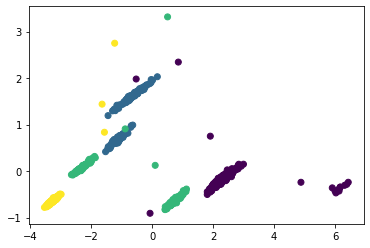

7335/7335 [==============================] - 12s 2ms/sample - loss: 2.8387 - ExpID_loss: 1.3994 - Y_output_loss: 2.3391 - C0_task_loss: 1.9634 - C1_task_loss: 1.6345 - Y_output_top3_acc: 0.2652 - val_loss: 2.8419 - val_ExpID_loss: 1.3927 - val_Y_output_loss: 2.3461 - val_C0_task_loss: 1.9613 - val_C1_task_loss: 1.6357 - val_Y_output_top3_acc: 0.3004
Epoch 2/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.8377 - ExpID_loss: 1.3993 - Y_output_loss: 2.3381 - C0_task_loss: 1.9633 - C1_task_loss: 1.6336 - Y_output_top3_acc: 0.2722

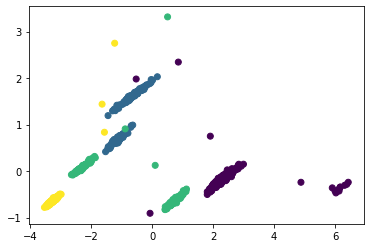

7335/7335 [==============================] - 9s 1ms/sample - loss: 2.8378 - ExpID_loss: 1.3993 - Y_output_loss: 2.3383 - C0_task_loss: 1.9628 - C1_task_loss: 1.6335 - Y_output_top3_acc: 0.2714 - val_loss: 2.8419 - val_ExpID_loss: 1.3931 - val_Y_output_loss: 2.3405 - val_C0_task_loss: 1.9621 - val_C1_task_loss: 1.6338 - val_Y_output_top3_acc: 0.3004
Epoch 3/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.7843 - ExpID_loss: 1.3882 - Y_output_loss: 2.2922 - C0_task_loss: 1.9386 - C1_task_loss: 1.5935 - Y_output_top3_acc: 0.3540

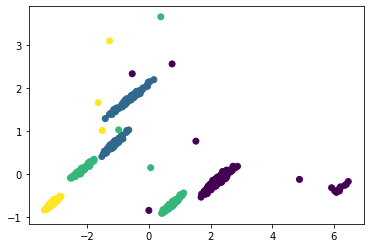

7335/7335 [==============================] - 9s 1ms/sample - loss: 2.7832 - ExpID_loss: 1.3882 - Y_output_loss: 2.2909 - C0_task_loss: 1.9380 - C1_task_loss: 1.5920 - Y_output_top3_acc: 0.3549 - val_loss: 2.7396 - val_ExpID_loss: 1.3854 - val_Y_output_loss: 2.2554 - val_C0_task_loss: 1.9144 - val_C1_task_loss: 1.5609 - val_Y_output_top3_acc: 0.3975
Epoch 4/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.7277 - ExpID_loss: 1.3816 - Y_output_loss: 2.2479 - C0_task_loss: 1.8956 - C1_task_loss: 1.5207 - Y_output_top3_acc: 0.3986

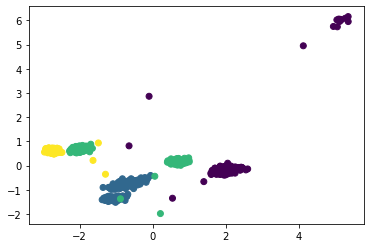

7335/7335 [==============================] - 9s 1ms/sample - loss: 2.7274 - ExpID_loss: 1.3817 - Y_output_loss: 2.2476 - C0_task_loss: 1.8952 - C1_task_loss: 1.5204 - Y_output_top3_acc: 0.3980 - val_loss: 2.6829 - val_ExpID_loss: 1.3779 - val_Y_output_loss: 2.2084 - val_C0_task_loss: 1.8690 - val_C1_task_loss: 1.4792 - val_Y_output_top3_acc: 0.4417
Epoch 5/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.6584 - ExpID_loss: 1.3765 - Y_output_loss: 2.1903 - C0_task_loss: 1.8283 - C1_task_loss: 1.4752 - Y_output_top3_acc: 0.4204

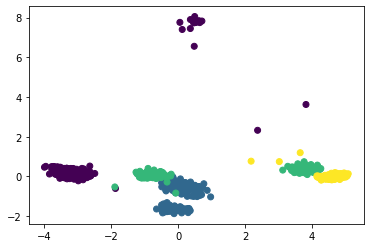

7335/7335 [==============================] - 9s 1ms/sample - loss: 2.6540 - ExpID_loss: 1.3757 - Y_output_loss: 2.1852 - C0_task_loss: 1.8221 - C1_task_loss: 1.4697 - Y_output_top3_acc: 0.4226 - val_loss: 2.5076 - val_ExpID_loss: 1.3638 - val_Y_output_loss: 2.0678 - val_C0_task_loss: 1.6766 - val_C1_task_loss: 1.4097 - val_Y_output_top3_acc: 0.4689
Epoch 6/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.4932 - ExpID_loss: 1.3552 - Y_output_loss: 2.0623 - C0_task_loss: 1.5763 - C1_task_loss: 1.3774 - Y_output_top3_acc: 0.5069

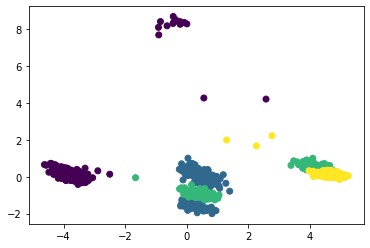

7335/7335 [==============================] - 10s 1ms/sample - loss: 2.4919 - ExpID_loss: 1.3545 - Y_output_loss: 2.0608 - C0_task_loss: 1.5741 - C1_task_loss: 1.3762 - Y_output_top3_acc: 0.5073 - val_loss: 2.3283 - val_ExpID_loss: 1.3380 - val_Y_output_loss: 1.8941 - val_C0_task_loss: 1.4999 - val_C1_task_loss: 1.3253 - val_Y_output_top3_acc: 0.5442
Epoch 7/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.3279 - ExpID_loss: 1.3210 - Y_output_loss: 1.9019 - C0_task_loss: 1.6033 - C1_task_loss: 1.3359 - Y_output_top3_acc: 0.5996

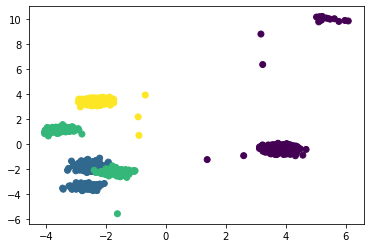

7335/7335 [==============================] - 9s 1ms/sample - loss: 2.3257 - ExpID_loss: 1.3203 - Y_output_loss: 1.8988 - C0_task_loss: 1.6023 - C1_task_loss: 1.3353 - Y_output_top3_acc: 0.5996 - val_loss: 2.0893 - val_ExpID_loss: 1.2755 - val_Y_output_loss: 1.6805 - val_C0_task_loss: 1.4911 - val_C1_task_loss: 1.3192 - val_Y_output_top3_acc: 0.7099
Epoch 8/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.4938 - ExpID_loss: 1.5957 - Y_output_loss: 1.9305 - C0_task_loss: 1.7775 - C1_task_loss: 2.2598 - Y_output_top3_acc: 0.5875

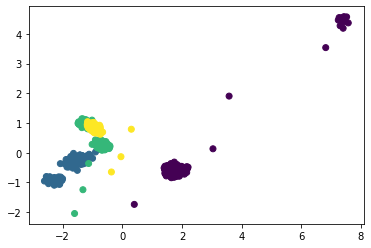

7335/7335 [==============================] - 10s 1ms/sample - loss: 2.4946 - ExpID_loss: 1.5893 - Y_output_loss: 1.9328 - C0_task_loss: 1.7753 - C1_task_loss: 2.2574 - Y_output_top3_acc: 0.5862 - val_loss: 2.2834 - val_ExpID_loss: 1.2843 - val_Y_output_loss: 1.8213 - val_C0_task_loss: 1.5604 - val_C1_task_loss: 1.8307 - val_Y_output_top3_acc: 0.5862
Epoch 9/30
7200/7335 [============================>.] - ETA: 0s - loss: 11.0457 - ExpID_loss: 4.0040 - Y_output_loss: 4.2858 - C0_task_loss: 42.3457 - C1_task_loss: 21.2498 - Y_output_top3_acc: 0.4308

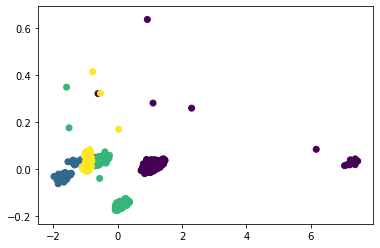

7335/7335 [==============================] - 10s 1ms/sample - loss: 11.1759 - ExpID_loss: 3.9780 - Y_output_loss: 4.2322 - C0_task_loss: 44.3781 - C1_task_loss: 21.6908 - Y_output_top3_acc: 0.4270 - val_loss: 20.3343 - val_ExpID_loss: 8.4190 - val_Y_output_loss: 2.3428 - val_C0_task_loss: 140.3190 - val_C1_task_loss: 30.4005 - val_Y_output_top3_acc: 0.2781
Epoch 10/30
7200/7335 [============================>.] - ETA: 0s - loss: 25.1306 - ExpID_loss: 9.4109 - Y_output_loss: 6.0156 - C0_task_loss: 153.2778 - C1_task_loss: 28.4621 - Y_output_top3_acc: 0.3369

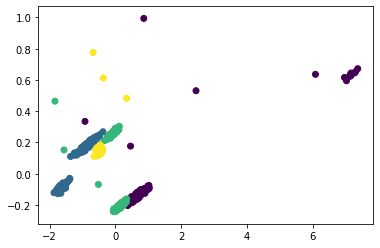

7335/7335 [==============================] - 9s 1ms/sample - loss: 24.7197 - ExpID_loss: 9.1940 - Y_output_loss: 5.9152 - C0_task_loss: 149.1876 - C1_task_loss: 27.7394 - Y_output_top3_acc: 0.3373 - val_loss: 2.8158 - val_ExpID_loss: 1.3864 - val_Y_output_loss: 2.2984 - val_C0_task_loss: 2.1832 - val_C1_task_loss: 1.6035 - val_Y_output_top3_acc: 0.3806
Epoch 11/30
7200/7335 [============================>.] - ETA: 0s - loss: 14.6414 - ExpID_loss: 1.8304 - Y_output_loss: 13.7841 - C0_task_loss: 2.2310 - C1_task_loss: 4.5113 - Y_output_top3_acc: 0.3658

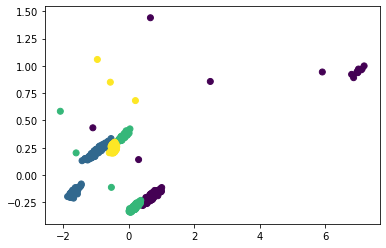

7335/7335 [==============================] - 9s 1ms/sample - loss: 14.5598 - ExpID_loss: 1.8458 - Y_output_loss: 13.6604 - C0_task_loss: 2.2232 - C1_task_loss: 4.5432 - Y_output_top3_acc: 0.3644 - val_loss: 3.6487 - val_ExpID_loss: 1.3861 - val_Y_output_loss: 2.2935 - val_C0_task_loss: 10.4088 - val_C1_task_loss: 1.5949 - val_Y_output_top3_acc: 0.3724
Epoch 12/30
7200/7335 [============================>.] - ETA: 0s - loss: 4.9129 - ExpID_loss: 1.7600 - Y_output_loss: 3.5224 - C0_task_loss: 10.5509 - C1_task_loss: 1.5946 - Y_output_top3_acc: 0.3746

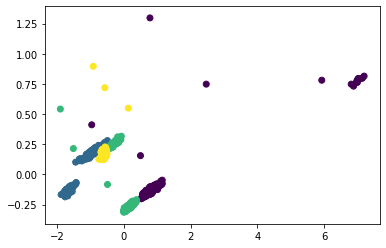

7335/7335 [==============================] - 9s 1ms/sample - loss: 4.8736 - ExpID_loss: 1.7499 - Y_output_loss: 3.4891 - C0_task_loss: 10.3178 - C1_task_loss: 1.5941 - Y_output_top3_acc: 0.3757 - val_loss: 3.9139 - val_ExpID_loss: 1.3864 - val_Y_output_loss: 2.2912 - val_C0_task_loss: 13.2842 - val_C1_task_loss: 1.5858 - val_Y_output_top3_acc: 0.3915
Epoch 13/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.1179 - ExpID_loss: 3.0180 - Y_output_loss: 2.2938 - C0_task_loss: 3.6409 - C1_task_loss: 1.5819 - Y_output_top3_acc: 0.3894

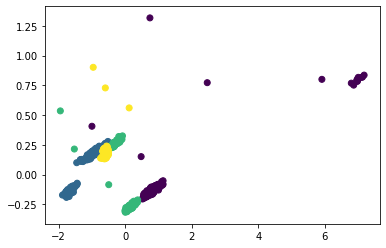

7335/7335 [==============================] - 9s 1ms/sample - loss: 3.1117 - ExpID_loss: 2.9739 - Y_output_loss: 2.2938 - C0_task_loss: 3.5943 - C1_task_loss: 1.5819 - Y_output_top3_acc: 0.3887 - val_loss: 2.7781 - val_ExpID_loss: 1.3863 - val_Y_output_loss: 2.2886 - val_C0_task_loss: 1.9322 - val_C1_task_loss: 1.5787 - val_Y_output_top3_acc: 0.3915
Epoch 14/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.7810 - ExpID_loss: 1.3860 - Y_output_loss: 2.2894 - C0_task_loss: 1.9560 - C1_task_loss: 1.5745 - Y_output_top3_acc: 0.3872

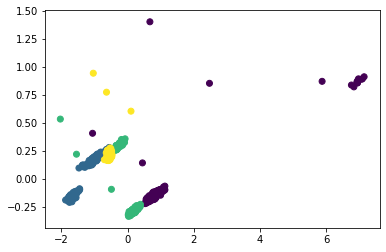

7335/7335 [==============================] - 9s 1ms/sample - loss: 2.7808 - ExpID_loss: 1.3859 - Y_output_loss: 2.2892 - C0_task_loss: 1.9552 - C1_task_loss: 1.5740 - Y_output_top3_acc: 0.3887 - val_loss: 2.7741 - val_ExpID_loss: 1.3861 - val_Y_output_loss: 2.2868 - val_C0_task_loss: 1.9293 - val_C1_task_loss: 1.5700 - val_Y_output_top3_acc: 0.3915
Epoch 15/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.7752 - ExpID_loss: 1.3858 - Y_output_loss: 2.2870 - C0_task_loss: 1.9296 - C1_task_loss: 1.5674 - Y_output_top3_acc: 0.3889

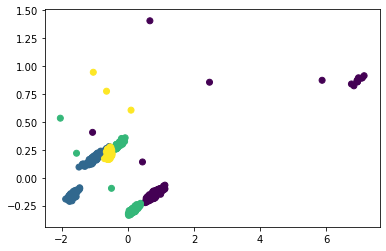

7335/7335 [==============================] - 9s 1ms/sample - loss: 2.7752 - ExpID_loss: 1.3859 - Y_output_loss: 2.2869 - C0_task_loss: 1.9296 - C1_task_loss: 1.5671 - Y_output_top3_acc: 0.3887 - val_loss: 2.7703 - val_ExpID_loss: 1.3866 - val_Y_output_loss: 2.2832 - val_C0_task_loss: 1.9240 - val_C1_task_loss: 1.5609 - val_Y_output_top3_acc: 0.3915
Epoch 16/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.7722 - ExpID_loss: 1.3858 - Y_output_loss: 2.2848 - C0_task_loss: 1.9267 - C1_task_loss: 1.5607 - Y_output_top3_acc: 0.3887

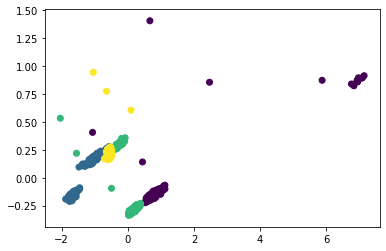

7335/7335 [==============================] - 9s 1ms/sample - loss: 2.7721 - ExpID_loss: 1.3858 - Y_output_loss: 2.2847 - C0_task_loss: 1.9268 - C1_task_loss: 1.5612 - Y_output_top3_acc: 0.3887 - val_loss: 2.7670 - val_ExpID_loss: 1.3862 - val_Y_output_loss: 2.2804 - val_C0_task_loss: 1.9225 - val_C1_task_loss: 1.5591 - val_Y_output_top3_acc: 0.3915
Epoch 17/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.7694 - ExpID_loss: 1.3857 - Y_output_loss: 2.2828 - C0_task_loss: 1.9243 - C1_task_loss: 1.5556 - Y_output_top3_acc: 0.3889Restoring model weights from the end of the best epoch.


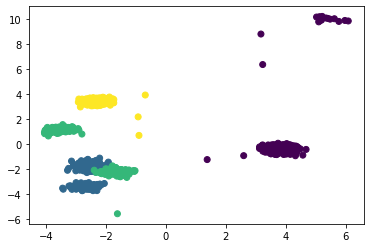

7335/7335 [==============================] - 10s 1ms/sample - loss: 2.7694 - ExpID_loss: 1.3857 - Y_output_loss: 2.2828 - C0_task_loss: 1.9242 - C1_task_loss: 1.5556 - Y_output_top3_acc: 0.3887 - val_loss: 2.7640 - val_ExpID_loss: 1.3859 - val_Y_output_loss: 2.2802 - val_C0_task_loss: 1.9182 - val_C1_task_loss: 1.5534 - val_Y_output_top3_acc: 0.3915
Epoch 00017: early stopping
Tensor("DN_DN1_ConcatOut_8/concat:0", shape=(?, 1500, 320), dtype=float32)
custom grad
Train on 7335 samples, validate on 1834 samples
Epoch 1/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.1635 - ExpID_loss: 1.3941 - Y_output_loss: 2.2119 - C0_task_loss: 1.8594 - C1_task_loss: 1.5043 - Y_output_top3_acc: 0.4197

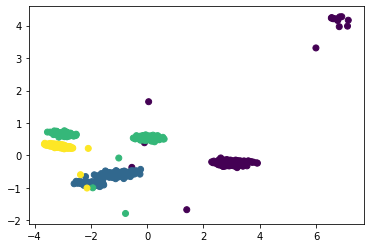

7335/7335 [==============================] - 12s 2ms/sample - loss: 3.1712 - ExpID_loss: 1.3963 - Y_output_loss: 2.2132 - C0_task_loss: 1.8796 - C1_task_loss: 1.5324 - Y_output_top3_acc: 0.4196 - val_loss: 3.8100 - val_ExpID_loss: 1.6075 - val_Y_output_loss: 2.1157 - val_C0_task_loss: 3.2654 - val_C1_task_loss: 3.5931 - val_Y_output_top3_acc: 0.4106
Epoch 2/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.9919 - ExpID_loss: 1.6325 - Y_output_loss: 2.2563 - C0_task_loss: 3.4241 - C1_task_loss: 3.6215 - Y_output_top3_acc: 0.4329

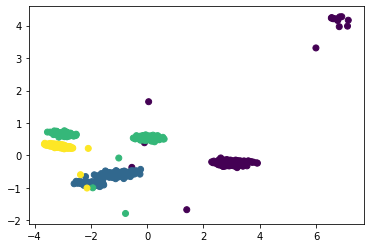

7335/7335 [==============================] - 9s 1ms/sample - loss: 3.9887 - ExpID_loss: 1.6335 - Y_output_loss: 2.2521 - C0_task_loss: 3.4204 - C1_task_loss: 3.6216 - Y_output_top3_acc: 0.4348 - val_loss: 3.8100 - val_ExpID_loss: 1.6120 - val_Y_output_loss: 2.1402 - val_C0_task_loss: 3.2126 - val_C1_task_loss: 3.5288 - val_Y_output_top3_acc: 0.4106
Epoch 3/30
7200/7335 [============================>.] - ETA: 0s - loss: 8.0637 - ExpID_loss: 2.2065 - Y_output_loss: 2.6574 - C0_task_loss: 11.2294 - C1_task_loss: 13.5960 - Y_output_top3_acc: 0.4338

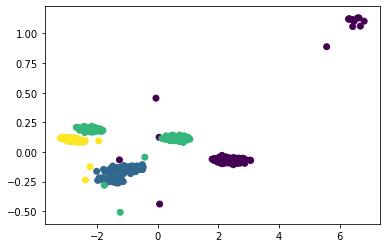

7335/7335 [==============================] - 9s 1ms/sample - loss: 8.2140 - ExpID_loss: 2.2539 - Y_output_loss: 2.6844 - C0_task_loss: 11.6260 - C1_task_loss: 14.1202 - Y_output_top3_acc: 0.4346 - val_loss: 13.0762 - val_ExpID_loss: 2.0577 - val_Y_output_loss: 2.2569 - val_C0_task_loss: 20.0112 - val_C1_task_loss: 32.7226 - val_Y_output_top3_acc: 0.5120
Epoch 4/30
7200/7335 [============================>.] - ETA: 0s - loss: 52.2262 - ExpID_loss: 14.2513 - Y_output_loss: 4.2382 - C0_task_loss: 99.0197 - C1_task_loss: 126.6689 - Y_output_top3_acc: 0.3689

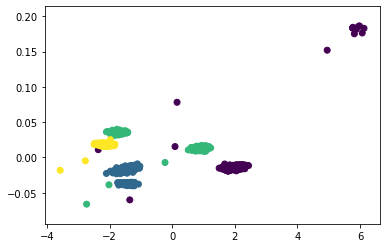

7335/7335 [==============================] - 10s 1ms/sample - loss: 53.2034 - ExpID_loss: 14.1576 - Y_output_loss: 4.1859 - C0_task_loss: 101.6410 - C1_task_loss: 131.5776 - Y_output_top3_acc: 0.3666 - val_loss: 49.9425 - val_ExpID_loss: 7.0022 - val_Y_output_loss: 9.4888 - val_C0_task_loss: 92.4672 - val_C1_task_loss: 100.8412 - val_Y_output_top3_acc: 0.2606
Epoch 5/30
7200/7335 [============================>.] - ETA: 0s - loss: 545.5535 - ExpID_loss: 382.2926 - Y_output_loss: 77.3081 - C0_task_loss: 921.8796 - C1_task_loss: 1037.0544 - Y_output_top3_acc: 0.2915

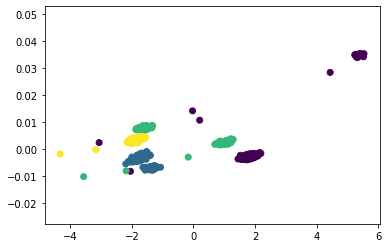

7335/7335 [==============================] - 10s 1ms/sample - loss: 550.0953 - ExpID_loss: 398.6821 - Y_output_loss: 75.2810 - C0_task_loss: 922.6785 - C1_task_loss: 1063.3492 - Y_output_top3_acc: 0.2905 - val_loss: 493.9619 - val_ExpID_loss: 720.4989 - val_Y_output_loss: 38.0571 - val_C0_task_loss: 1283.3033 - val_C1_task_loss: 271.2437 - val_Y_output_top3_acc: 0.2623
Epoch 6/30
7200/7335 [============================>.] - ETA: 0s - loss: 8304.2559 - ExpID_loss: 7009.1196 - Y_output_loss: 2487.0095 - C0_task_loss: 10964.6523 - C1_task_loss: 11112.4570 - Y_output_top3_acc: 0.2917

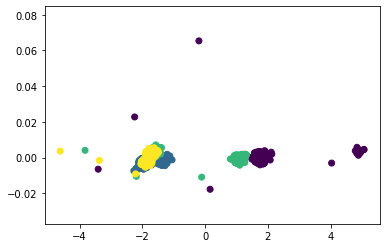

7335/7335 [==============================] - 10s 1ms/sample - loss: 9545.1250 - ExpID_loss: 7722.9512 - Y_output_loss: 3553.3853 - C0_task_loss: 12988.9004 - C1_task_loss: 12153.3867 - Y_output_top3_acc: 0.2935 - val_loss: 29366.3108 - val_ExpID_loss: 24788.5586 - val_Y_output_loss: 13313.5732 - val_C0_task_loss: 33416.5312 - val_C1_task_loss: 21902.7207 - val_Y_output_top3_acc: 0.3768
Epoch 7/30
7200/7335 [============================>.] - ETA: 0s - loss: 47399.7964 - ExpID_loss: 47706.4180 - Y_output_loss: 11383.9463 - C0_task_loss: 51252.0547 - C1_task_loss: 81120.7812 - Y_output_top3_acc: 0.3089

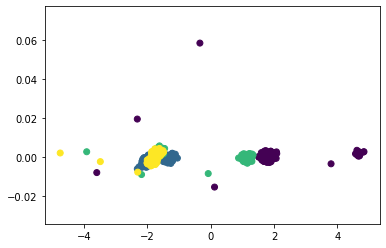

7335/7335 [==============================] - 9s 1ms/sample - loss: 49573.8445 - ExpID_loss: 52011.9609 - Y_output_loss: 11753.2773 - C0_task_loss: 56214.5742 - C1_task_loss: 85968.6719 - Y_output_top3_acc: 0.3081 - val_loss: 157144.2298 - val_ExpID_loss: 175748.9531 - val_Y_output_loss: 50899.7344 - val_C0_task_loss: 237977.0469 - val_C1_task_loss: 115292.0469 - val_Y_output_top3_acc: 0.2606
Epoch 8/30
7200/7335 [============================>.] - ETA: 0s - loss: 175248.8150 - ExpID_loss: 175040.3125 - Y_output_loss: 91139.2188 - C0_task_loss: 71976.9062 - C1_task_loss: 173530.6250 - Y_output_top3_acc: 0.3129

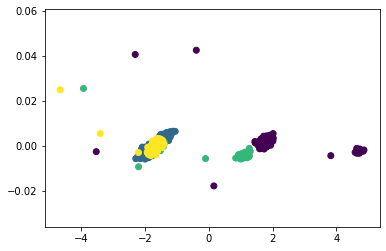

7335/7335 [==============================] - 10s 1ms/sample - loss: 172023.4370 - ExpID_loss: 170309.5469 - Y_output_loss: 88676.0547 - C0_task_loss: 70031.6328 - C1_task_loss: 168840.6562 - Y_output_top3_acc: 0.3133 - val_loss: 3.2805 - val_ExpID_loss: 1.3865 - val_Y_output_loss: 2.2992 - val_C0_task_loss: 1.9314 - val_C1_task_loss: 1.5927 - val_Y_output_top3_acc: 0.3615
Epoch 9/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.2792 - ExpID_loss: 1.3864 - Y_output_loss: 2.2977 - C0_task_loss: 1.9314 - C1_task_loss: 1.5898 - Y_output_top3_acc: 0.3722

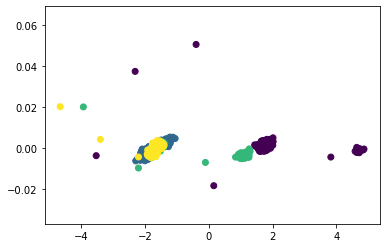

7335/7335 [==============================] - 9s 1ms/sample - loss: 3.2792 - ExpID_loss: 1.3864 - Y_output_loss: 2.2977 - C0_task_loss: 1.9311 - C1_task_loss: 1.5895 - Y_output_top3_acc: 0.3719 - val_loss: 3.2770 - val_ExpID_loss: 1.3863 - val_Y_output_loss: 2.2967 - val_C0_task_loss: 1.9254 - val_C1_task_loss: 1.5869 - val_Y_output_top3_acc: 0.3615
Epoch 10/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.2758 - ExpID_loss: 1.3863 - Y_output_loss: 2.2959 - C0_task_loss: 1.9292 - C1_task_loss: 1.5840 - Y_output_top3_acc: 0.3792

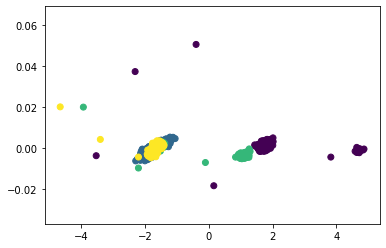

7335/7335 [==============================] - 9s 1ms/sample - loss: 3.2758 - ExpID_loss: 1.3863 - Y_output_loss: 2.2959 - C0_task_loss: 1.9291 - C1_task_loss: 1.5838 - Y_output_top3_acc: 0.3789 - val_loss: 3.2730 - val_ExpID_loss: 1.3861 - val_Y_output_loss: 2.2945 - val_C0_task_loss: 1.9283 - val_C1_task_loss: 1.5809 - val_Y_output_top3_acc: 0.3915
Epoch 11/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.2720 - ExpID_loss: 1.3862 - Y_output_loss: 2.2938 - C0_task_loss: 1.9270 - C1_task_loss: 1.5778 - Y_output_top3_acc: 0.3893Restoring model weights from the end of the best epoch.


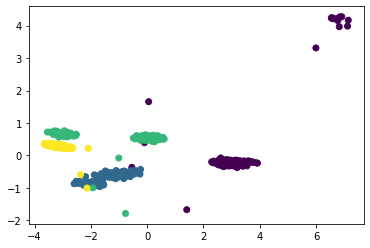

7335/7335 [==============================] - 10s 1ms/sample - loss: 3.2721 - ExpID_loss: 1.3863 - Y_output_loss: 2.2939 - C0_task_loss: 1.9270 - C1_task_loss: 1.5778 - Y_output_top3_acc: 0.3887 - val_loss: 3.2688 - val_ExpID_loss: 1.3863 - val_Y_output_loss: 2.2917 - val_C0_task_loss: 1.9216 - val_C1_task_loss: 1.5729 - val_Y_output_top3_acc: 0.3915
Epoch 00011: early stopping
Tensor("DN_DN1_ConcatOut_9/concat:0", shape=(?, 1500, 320), dtype=float32)
custom grad
Train on 7335 samples, validate on 1834 samples
Epoch 1/30
7200/7335 [============================>.] - ETA: 0s - loss: 16.8474 - ExpID_loss: 4.3320 - Y_output_loss: 4.9755 - C0_task_loss: 10.9042 - C1_task_loss: 24.3370 - Y_output_top3_acc: 0.3557

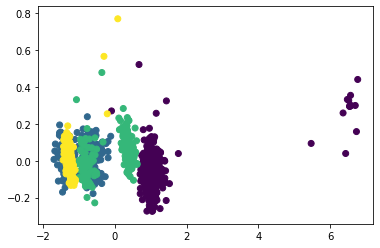

7335/7335 [==============================] - 12s 2ms/sample - loss: 18.5942 - ExpID_loss: 4.9939 - Y_output_loss: 4.9033 - C0_task_loss: 13.4420 - C1_task_loss: 29.9280 - Y_output_top3_acc: 0.3538 - val_loss: 114.8697 - val_ExpID_loss: 48.3584 - val_Y_output_loss: 2.4160 - val_C0_task_loss: 138.6239 - val_C1_task_loss: 187.0382 - val_Y_output_top3_acc: 0.2568
Epoch 2/30
7200/7335 [============================>.] - ETA: 0s - loss: 173.3615 - ExpID_loss: 61.1927 - Y_output_loss: 2.5447 - C0_task_loss: 157.7773 - C1_task_loss: 350.4197 - Y_output_top3_acc: 0.2629

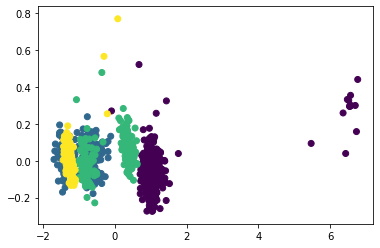

7335/7335 [==============================] - 10s 1ms/sample - loss: 173.5800 - ExpID_loss: 61.1038 - Y_output_loss: 2.5445 - C0_task_loss: 157.7966 - C1_task_loss: 351.5589 - Y_output_top3_acc: 0.2634 - val_loss: 114.8697 - val_ExpID_loss: 47.9696 - val_Y_output_loss: 2.4154 - val_C0_task_loss: 139.0277 - val_C1_task_loss: 189.0129 - val_Y_output_top3_acc: 0.2568
Epoch 3/30
7200/7335 [============================>.] - ETA: 0s - loss: 211.6775 - ExpID_loss: 89.4958 - Y_output_loss: 3.2321 - C0_task_loss: 153.2431 - C1_task_loss: 452.0790 - Y_output_top3_acc: 0.3043

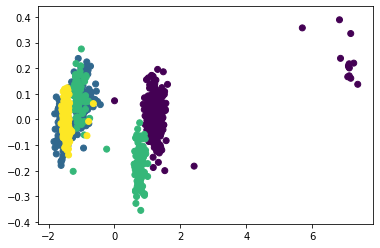

7335/7335 [==============================] - 10s 1ms/sample - loss: 212.1781 - ExpID_loss: 90.8407 - Y_output_loss: 3.3589 - C0_task_loss: 152.5482 - C1_task_loss: 453.4568 - Y_output_top3_acc: 0.3067 - val_loss: 79.3409 - val_ExpID_loss: 29.5301 - val_Y_output_loss: 5.5585 - val_C0_task_loss: 103.6583 - val_C1_task_loss: 114.8978 - val_Y_output_top3_acc: 0.3909
Epoch 4/30
7200/7335 [============================>.] - ETA: 0s - loss: 1201.0544 - ExpID_loss: 1545.9009 - Y_output_loss: 41.6823 - C0_task_loss: 318.7788 - C1_task_loss: 1999.8937 - Y_output_top3_acc: 0.3453

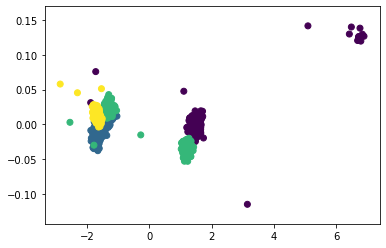

7335/7335 [==============================] - 10s 1ms/sample - loss: 1260.3398 - ExpID_loss: 1683.7898 - Y_output_loss: 40.8861 - C0_task_loss: 371.7051 - C1_task_loss: 2101.9285 - Y_output_top3_acc: 0.3448 - val_loss: 3746.1877 - val_ExpID_loss: 3970.4324 - val_Y_output_loss: 627.5839 - val_C0_task_loss: 2384.2551 - val_C1_task_loss: 4092.6680 - val_Y_output_top3_acc: 0.3702
Epoch 5/30
7200/7335 [============================>.] - ETA: 0s - loss: 96697.4433 - ExpID_loss: 172698.5312 - Y_output_loss: 9414.7998 - C0_task_loss: 39897.0781 - C1_task_loss: 78346.5312 - Y_output_top3_acc: 0.3435

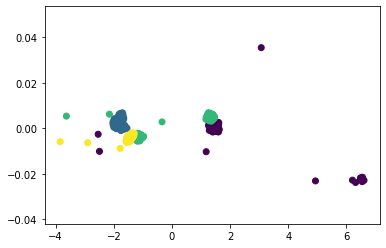

7335/7335 [==============================] - 10s 1ms/sample - loss: 105315.7932 - ExpID_loss: 187898.8906 - Y_output_loss: 11163.3477 - C0_task_loss: 52927.7617 - C1_task_loss: 86472.9062 - Y_output_top3_acc: 0.3441 - val_loss: 252600.5246 - val_ExpID_loss: 381574.7188 - val_Y_output_loss: 2.3010 - val_C0_task_loss: 375085.1875 - val_C1_task_loss: 89073.5703 - val_Y_output_top3_acc: 0.3746
Epoch 6/30
7200/7335 [============================>.] - ETA: 0s - loss: 5842223.2361 - ExpID_loss: 8390588.0000 - Y_output_loss: 504084.2812 - C0_task_loss: 4530278.0000 - C1_task_loss: 4872929.0000 - Y_output_top3_acc: 0.3487

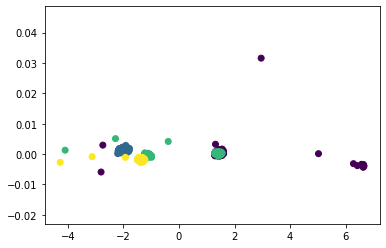

7335/7335 [==============================] - 10s 1ms/sample - loss: 6249114.9434 - ExpID_loss: 9033518.0000 - Y_output_loss: 581176.5625 - C0_task_loss: 5021819.5000 - C1_task_loss: 5473176.0000 - Y_output_top3_acc: 0.3464 - val_loss: 20775404.1091 - val_ExpID_loss: 4596020.0000 - val_Y_output_loss: 8572026.0000 - val_C0_task_loss: 24453804.0000 - val_C1_task_loss: 11576393.0000 - val_Y_output_top3_acc: 0.2912
Epoch 7/30
7200/7335 [============================>.] - ETA: 0s - loss: 281614915.1111 - ExpID_loss: 272719488.0000 - Y_output_loss: 41677608.0000 - C0_task_loss: 270635360.0000 - C1_task_loss: 256436160.0000 - Y_output_top3_acc: 0.3462

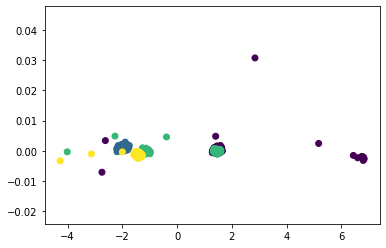

7335/7335 [==============================] - 10s 1ms/sample - loss: 306637607.1766 - ExpID_loss: 301014432.0000 - Y_output_loss: 51166004.0000 - C0_task_loss: 299135392.0000 - C1_task_loss: 290496608.0000 - Y_output_top3_acc: 0.3467 - val_loss: 788896600.7764 - val_ExpID_loss: 382797984.0000 - val_Y_output_loss: 234033328.0000 - val_C0_task_loss: 532041568.0000 - val_C1_task_loss: 917290368.0000 - val_Y_output_top3_acc: 0.3702
Epoch 8/30
7200/7335 [============================>.] - ETA: 0s - loss: 7346052679.1111 - ExpID_loss: 6496207360.0000 - Y_output_loss: 705202944.0000 - C0_task_loss: 9428164608.0000 - C1_task_loss: 6211792896.0000 - Y_output_top3_acc: 0.3313

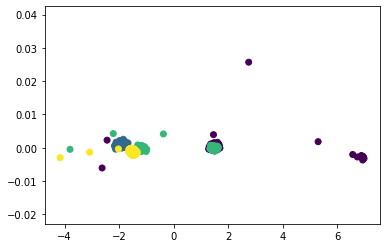

7335/7335 [==============================] - 10s 1ms/sample - loss: 7469758244.8207 - ExpID_loss: 6753099776.0000 - Y_output_loss: 732873600.0000 - C0_task_loss: 9708668928.0000 - C1_task_loss: 6187686400.0000 - Y_output_top3_acc: 0.3294 - val_loss: 7233369160.0262 - val_ExpID_loss: 8432651264.0000 - val_Y_output_loss: 2.3014 - val_C0_task_loss: 8597357568.0000 - val_C1_task_loss: 7258306048.0000 - val_Y_output_top3_acc: 0.2655
Epoch 9/30
7200/7335 [============================>.] - ETA: 0s - loss: 7228514904.2368 - ExpID_loss: 5820260352.0000 - Y_output_loss: 2574329600.0000 - C0_task_loss: 3391696128.0000 - C1_task_loss: 6301993984.0000 - Y_output_top3_acc: 0.2738

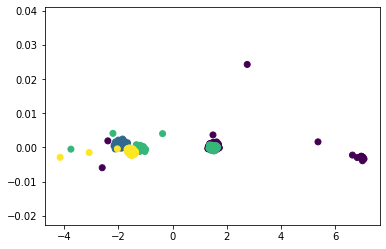

7335/7335 [==============================] - 10s 1ms/sample - loss: 7095474752.6946 - ExpID_loss: 5662956032.0000 - Y_output_loss: 2504753152.0000 - C0_task_loss: 3300028672.0000 - C1_task_loss: 6131670016.0000 - Y_output_top3_acc: 0.2740 - val_loss: 3.7792 - val_ExpID_loss: 1.3868 - val_Y_output_loss: 2.3012 - val_C0_task_loss: 1.9412 - val_C1_task_loss: 1.6009 - val_Y_output_top3_acc: 0.2563
Epoch 10/30
7200/7335 [============================>.] - ETA: 0s - loss: 768058956.1080 - ExpID_loss: 209982464.0000 - Y_output_loss: 74331336.0000 - C0_task_loss: 372401440.0000 - C1_task_loss: 1730041472.0000 - Y_output_top3_acc: 0.3489

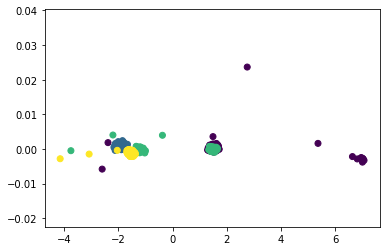

7335/7335 [==============================] - 10s 1ms/sample - loss: 826287173.9956 - ExpID_loss: 204307264.0000 - Y_output_loss: 178587040.0000 - C0_task_loss: 362336544.0000 - C1_task_loss: 1683283584.0000 - Y_output_top3_acc: 0.3478 - val_loss: 3.7745 - val_ExpID_loss: 1.3861 - val_Y_output_loss: 2.3002 - val_C0_task_loss: 1.9397 - val_C1_task_loss: 1.5925 - val_Y_output_top3_acc: 0.3730
Epoch 11/30
7200/7335 [============================>.] - ETA: 0s - loss: 136424820.7918 - ExpID_loss: 1.3870 - Y_output_loss: 88886232.0000 - C0_task_loss: 1.9368 - C1_task_loss: 158461952.0000 - Y_output_top3_acc: 0.3658

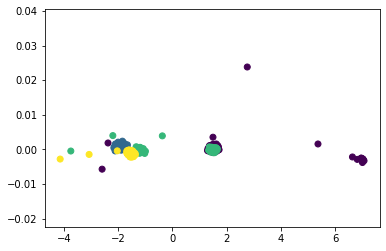

7335/7335 [==============================] - 10s 1ms/sample - loss: 134607580.1637 - ExpID_loss: 1.3870 - Y_output_loss: 87502496.0000 - C0_task_loss: 1.9368 - C1_task_loss: 154179200.0000 - Y_output_top3_acc: 0.3639 - val_loss: 3.7696 - val_ExpID_loss: 1.3865 - val_Y_output_loss: 2.2983 - val_C0_task_loss: 1.9328 - val_C1_task_loss: 1.5836 - val_Y_output_top3_acc: 0.3730
Epoch 12/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.7679 - ExpID_loss: 1.3868 - Y_output_loss: 2.2976 - C0_task_loss: 1.9337 - C1_task_loss: 1.5806 - Y_output_top3_acc: 0.3693

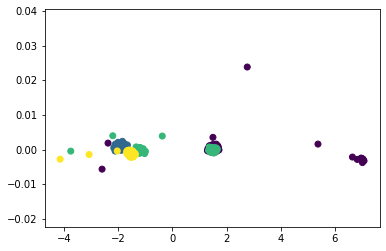

7335/7335 [==============================] - 10s 1ms/sample - loss: 3.7678 - ExpID_loss: 1.3868 - Y_output_loss: 2.2975 - C0_task_loss: 1.9339 - C1_task_loss: 1.5805 - Y_output_top3_acc: 0.3691 - val_loss: 3.7639 - val_ExpID_loss: 1.3863 - val_Y_output_loss: 2.2958 - val_C0_task_loss: 1.9312 - val_C1_task_loss: 1.5749 - val_Y_output_top3_acc: 0.3730
Epoch 13/30
7200/7335 [============================>.] - ETA: 0s - loss: 3011.3025 - ExpID_loss: 1.3867 - Y_output_loss: 2.2954 - C0_task_loss: 1.9311 - C1_task_loss: 10026.7061 - Y_output_top3_acc: 0.3696

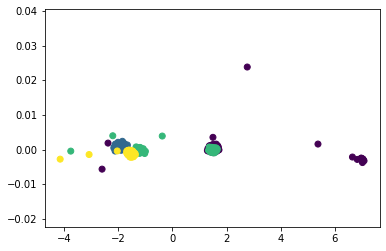

7335/7335 [==============================] - 10s 1ms/sample - loss: 2955.9490 - ExpID_loss: 1.3866 - Y_output_loss: 2.2955 - C0_task_loss: 1.9308 - C1_task_loss: 9755.7559 - Y_output_top3_acc: 0.3691 - val_loss: 3.7585 - val_ExpID_loss: 1.3857 - val_Y_output_loss: 2.2933 - val_C0_task_loss: 1.9278 - val_C1_task_loss: 1.5672 - val_Y_output_top3_acc: 0.3730
Epoch 14/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.7580 - ExpID_loss: 1.3865 - Y_output_loss: 2.2934 - C0_task_loss: 1.9285 - C1_task_loss: 1.5672 - Y_output_top3_acc: 0.3706

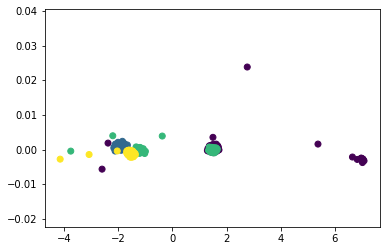

7335/7335 [==============================] - 9s 1ms/sample - loss: 3.7580 - ExpID_loss: 1.3865 - Y_output_loss: 2.2936 - C0_task_loss: 1.9284 - C1_task_loss: 1.5667 - Y_output_top3_acc: 0.3691 - val_loss: 3.7536 - val_ExpID_loss: 1.3861 - val_Y_output_loss: 2.2909 - val_C0_task_loss: 1.9278 - val_C1_task_loss: 1.5623 - val_Y_output_top3_acc: 0.3730
Epoch 15/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.7535 - ExpID_loss: 1.3863 - Y_output_loss: 2.2915 - C0_task_loss: 1.9261 - C1_task_loss: 1.5609 - Y_output_top3_acc: 0.3699

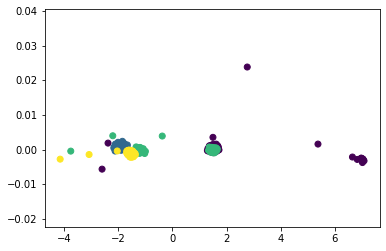

7335/7335 [==============================] - 10s 1ms/sample - loss: 3.7537 - ExpID_loss: 1.3863 - Y_output_loss: 2.2918 - C0_task_loss: 1.9261 - C1_task_loss: 1.5611 - Y_output_top3_acc: 0.3691 - val_loss: 3.7490 - val_ExpID_loss: 1.3863 - val_Y_output_loss: 2.2911 - val_C0_task_loss: 1.9251 - val_C1_task_loss: 1.5582 - val_Y_output_top3_acc: 0.3730
Epoch 16/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.7499 - ExpID_loss: 1.3862 - Y_output_loss: 2.2899 - C0_task_loss: 1.9244 - C1_task_loss: 1.5561 - Y_output_top3_acc: 0.3683

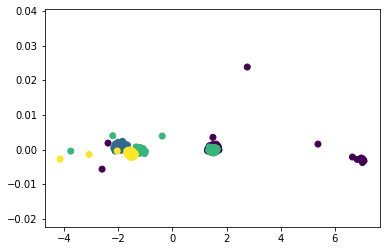

7335/7335 [==============================] - 9s 1ms/sample - loss: 3.7498 - ExpID_loss: 1.3862 - Y_output_loss: 2.2900 - C0_task_loss: 1.9238 - C1_task_loss: 1.5559 - Y_output_top3_acc: 0.3691 - val_loss: 3.7449 - val_ExpID_loss: 1.3861 - val_Y_output_loss: 2.2886 - val_C0_task_loss: 1.9198 - val_C1_task_loss: 1.5538 - val_Y_output_top3_acc: 0.3730
Epoch 17/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.7461 - ExpID_loss: 1.3861 - Y_output_loss: 2.2884 - C0_task_loss: 1.9219 - C1_task_loss: 1.5511 - Y_output_top3_acc: 0.3729

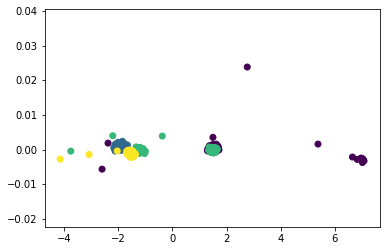

7335/7335 [==============================] - 10s 1ms/sample - loss: 3.7462 - ExpID_loss: 1.3861 - Y_output_loss: 2.2883 - C0_task_loss: 1.9222 - C1_task_loss: 1.5515 - Y_output_top3_acc: 0.3733 - val_loss: 3.7410 - val_ExpID_loss: 1.3858 - val_Y_output_loss: 2.2850 - val_C0_task_loss: 1.9188 - val_C1_task_loss: 1.5507 - val_Y_output_top3_acc: 0.3915
Epoch 18/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.7431 - ExpID_loss: 1.3860 - Y_output_loss: 2.2868 - C0_task_loss: 1.9202 - C1_task_loss: 1.5480 - Y_output_top3_acc: 0.3882

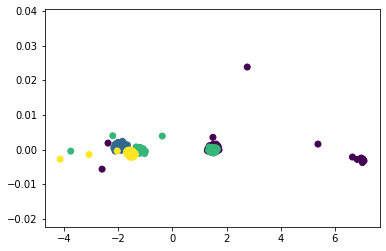

7335/7335 [==============================] - 9s 1ms/sample - loss: 3.7429 - ExpID_loss: 1.3860 - Y_output_loss: 2.2867 - C0_task_loss: 1.9204 - C1_task_loss: 1.5470 - Y_output_top3_acc: 0.3887 - val_loss: 3.7375 - val_ExpID_loss: 1.3856 - val_Y_output_loss: 2.2849 - val_C0_task_loss: 1.9169 - val_C1_task_loss: 1.5458 - val_Y_output_top3_acc: 0.3915
Epoch 19/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.7401 - ExpID_loss: 1.3860 - Y_output_loss: 2.2855 - C0_task_loss: 1.9190 - C1_task_loss: 1.5436 - Y_output_top3_acc: 0.3875

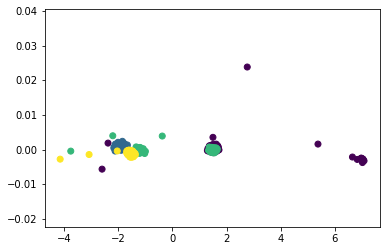

7335/7335 [==============================] - 10s 1ms/sample - loss: 3.7399 - ExpID_loss: 1.3860 - Y_output_loss: 2.2852 - C0_task_loss: 1.9187 - C1_task_loss: 1.5438 - Y_output_top3_acc: 0.3887 - val_loss: 3.7343 - val_ExpID_loss: 1.3861 - val_Y_output_loss: 2.2812 - val_C0_task_loss: 1.9142 - val_C1_task_loss: 1.5395 - val_Y_output_top3_acc: 0.3915
Epoch 20/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.7374 - ExpID_loss: 1.3859 - Y_output_loss: 2.2840 - C0_task_loss: 1.9177 - C1_task_loss: 1.5411 - Y_output_top3_acc: 0.3886

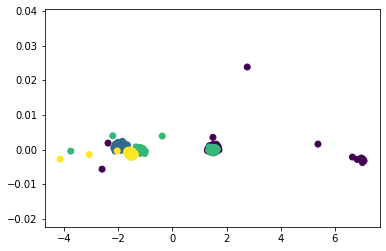

7335/7335 [==============================] - 9s 1ms/sample - loss: 3.7371 - ExpID_loss: 1.3859 - Y_output_loss: 2.2839 - C0_task_loss: 1.9173 - C1_task_loss: 1.5403 - Y_output_top3_acc: 0.3887 - val_loss: 3.7313 - val_ExpID_loss: 1.3865 - val_Y_output_loss: 2.2807 - val_C0_task_loss: 1.9123 - val_C1_task_loss: 1.5347 - val_Y_output_top3_acc: 0.3915
Epoch 21/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.7348 - ExpID_loss: 1.3859 - Y_output_loss: 2.2830 - C0_task_loss: 1.9163 - C1_task_loss: 1.5374 - Y_output_top3_acc: 0.3868

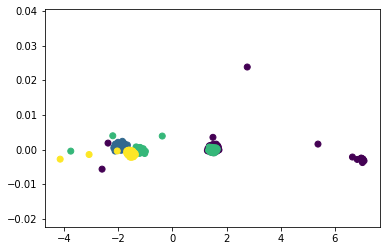

7335/7335 [==============================] - 9s 1ms/sample - loss: 3.7346 - ExpID_loss: 1.3858 - Y_output_loss: 2.2825 - C0_task_loss: 1.9162 - C1_task_loss: 1.5379 - Y_output_top3_acc: 0.3887 - val_loss: 3.7285 - val_ExpID_loss: 1.3862 - val_Y_output_loss: 2.2783 - val_C0_task_loss: 1.9103 - val_C1_task_loss: 1.5389 - val_Y_output_top3_acc: 0.3915
Epoch 22/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.7323 - ExpID_loss: 1.3858 - Y_output_loss: 2.2816 - C0_task_loss: 1.9149 - C1_task_loss: 1.5350 - Y_output_top3_acc: 0.3881

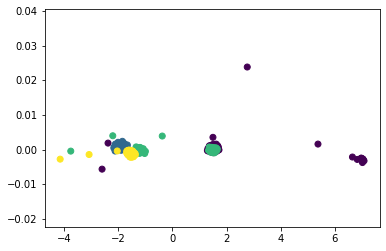

7335/7335 [==============================] - 9s 1ms/sample - loss: 3.7323 - ExpID_loss: 1.3858 - Y_output_loss: 2.2814 - C0_task_loss: 1.9152 - C1_task_loss: 1.5354 - Y_output_top3_acc: 0.3887 - val_loss: 3.7260 - val_ExpID_loss: 1.3855 - val_Y_output_loss: 2.2787 - val_C0_task_loss: 1.9157 - val_C1_task_loss: 1.5353 - val_Y_output_top3_acc: 0.3915
Epoch 23/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.7296 - ExpID_loss: 1.3857 - Y_output_loss: 2.2801 - C0_task_loss: 1.9137 - C1_task_loss: 1.5322 - Y_output_top3_acc: 0.3901

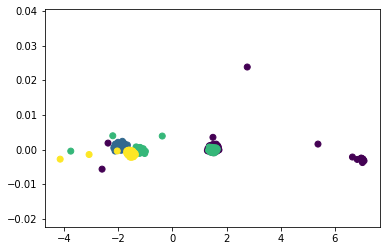

7335/7335 [==============================] - 10s 1ms/sample - loss: 3.7302 - ExpID_loss: 1.3858 - Y_output_loss: 2.2805 - C0_task_loss: 1.9143 - C1_task_loss: 1.5335 - Y_output_top3_acc: 0.3887 - val_loss: 3.7237 - val_ExpID_loss: 1.3855 - val_Y_output_loss: 2.2764 - val_C0_task_loss: 1.9101 - val_C1_task_loss: 1.5276 - val_Y_output_top3_acc: 0.3915
Epoch 24/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.7277 - ExpID_loss: 1.3858 - Y_output_loss: 2.2791 - C0_task_loss: 1.9128 - C1_task_loss: 1.5301 - Y_output_top3_acc: 0.3887

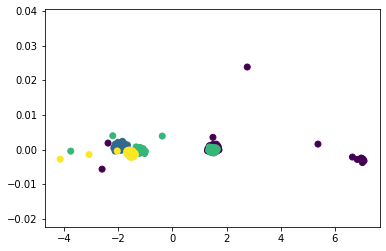

7335/7335 [==============================] - 10s 1ms/sample - loss: 3.7284 - ExpID_loss: 1.3857 - Y_output_loss: 2.2795 - C0_task_loss: 1.9134 - C1_task_loss: 1.5317 - Y_output_top3_acc: 0.3887 - val_loss: 3.7216 - val_ExpID_loss: 1.3862 - val_Y_output_loss: 2.2750 - val_C0_task_loss: 1.9072 - val_C1_task_loss: 1.5264 - val_Y_output_top3_acc: 0.3915
Epoch 25/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.7266 - ExpID_loss: 1.3857 - Y_output_loss: 2.2784 - C0_task_loss: 1.9123 - C1_task_loss: 1.5293 - Y_output_top3_acc: 0.3885

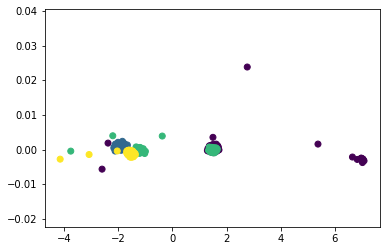

7335/7335 [==============================] - 10s 1ms/sample - loss: 3.7267 - ExpID_loss: 1.3857 - Y_output_loss: 2.2784 - C0_task_loss: 1.9125 - C1_task_loss: 1.5297 - Y_output_top3_acc: 0.3887 - val_loss: 3.7198 - val_ExpID_loss: 1.3862 - val_Y_output_loss: 2.2760 - val_C0_task_loss: 1.9067 - val_C1_task_loss: 1.5251 - val_Y_output_top3_acc: 0.3915
Epoch 26/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.7251 - ExpID_loss: 1.3857 - Y_output_loss: 2.2777 - C0_task_loss: 1.9113 - C1_task_loss: 1.5277 - Y_output_top3_acc: 0.3889

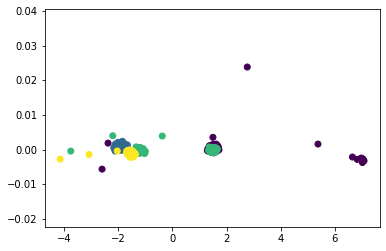

7335/7335 [==============================] - 9s 1ms/sample - loss: 3.7252 - ExpID_loss: 1.3857 - Y_output_loss: 2.2775 - C0_task_loss: 1.9119 - C1_task_loss: 1.5283 - Y_output_top3_acc: 0.3887 - val_loss: 3.7180 - val_ExpID_loss: 1.3861 - val_Y_output_loss: 2.2706 - val_C0_task_loss: 1.9078 - val_C1_task_loss: 1.5189 - val_Y_output_top3_acc: 0.3915
Epoch 27/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.7241 - ExpID_loss: 1.3856 - Y_output_loss: 2.2768 - C0_task_loss: 1.9113 - C1_task_loss: 1.5276 - Y_output_top3_acc: 0.3879

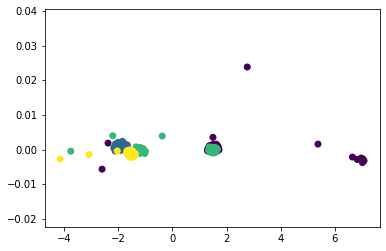

7335/7335 [==============================] - 9s 1ms/sample - loss: 3.7238 - ExpID_loss: 1.3857 - Y_output_loss: 2.2767 - C0_task_loss: 1.9111 - C1_task_loss: 1.5265 - Y_output_top3_acc: 0.3887 - val_loss: 3.7164 - val_ExpID_loss: 1.3860 - val_Y_output_loss: 2.2748 - val_C0_task_loss: 1.9060 - val_C1_task_loss: 1.5234 - val_Y_output_top3_acc: 0.3915
Epoch 28/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.7232 - ExpID_loss: 1.3857 - Y_output_loss: 2.2762 - C0_task_loss: 1.9106 - C1_task_loss: 1.5269 - Y_output_top3_acc: 0.3885

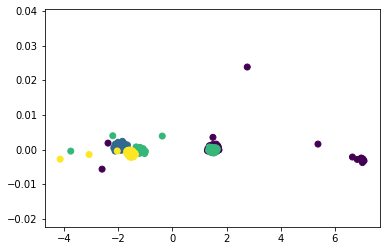

7335/7335 [==============================] - 9s 1ms/sample - loss: 3.7226 - ExpID_loss: 1.3856 - Y_output_loss: 2.2759 - C0_task_loss: 1.9106 - C1_task_loss: 1.5252 - Y_output_top3_acc: 0.3887 - val_loss: 3.7150 - val_ExpID_loss: 1.3868 - val_Y_output_loss: 2.2722 - val_C0_task_loss: 1.9007 - val_C1_task_loss: 1.5124 - val_Y_output_top3_acc: 0.3915
Epoch 29/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.7210 - ExpID_loss: 1.3856 - Y_output_loss: 2.2748 - C0_task_loss: 1.9101 - C1_task_loss: 1.5249 - Y_output_top3_acc: 0.3896

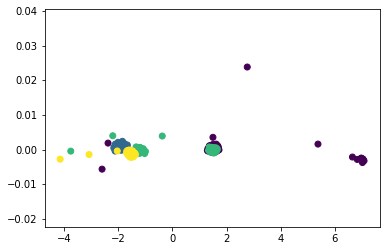

7335/7335 [==============================] - 9s 1ms/sample - loss: 3.7215 - ExpID_loss: 1.3856 - Y_output_loss: 2.2756 - C0_task_loss: 1.9101 - C1_task_loss: 1.5247 - Y_output_top3_acc: 0.3887 - val_loss: 3.7136 - val_ExpID_loss: 1.3866 - val_Y_output_loss: 2.2696 - val_C0_task_loss: 1.9008 - val_C1_task_loss: 1.5171 - val_Y_output_top3_acc: 0.3915
Epoch 30/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.7208 - ExpID_loss: 1.3856 - Y_output_loss: 2.2750 - C0_task_loss: 1.9095 - C1_task_loss: 1.5241 - Y_output_top3_acc: 0.3881

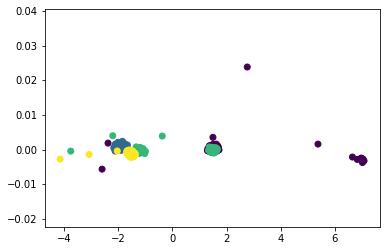

7335/7335 [==============================] - 9s 1ms/sample - loss: 3.7205 - ExpID_loss: 1.3856 - Y_output_loss: 2.2746 - C0_task_loss: 1.9097 - C1_task_loss: 1.5238 - Y_output_top3_acc: 0.3887 - val_loss: 3.7125 - val_ExpID_loss: 1.3859 - val_Y_output_loss: 2.2704 - val_C0_task_loss: 1.9130 - val_C1_task_loss: 1.5230 - val_Y_output_top3_acc: 0.3915


In [190]:

epochs = 30; #training_parameters["nepochs"]
batchsize =200;

from tensorflow.math import confusion_matrix
import tensorflow.keras as keras
from tensorflow.keras import layers 
#lrate = 0.001

LRATE_MAX = 0.001;
BURNIN_EPOCHS = 10;

c_loss =0.0;
CLOSS_MAX = 0.1;

closs_variable = keras.backend.variable(1.)

es = keras.callbacks.EarlyStopping(monitor='val_Y_output_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)
model_opt = keras.optimizers.Adam(learning_rate=0.0);



class Top3AccStrong(tf.keras.callbacks.Callback):
    def __init__(self):
        self.top3acc_strong = []
    def on_epoch_end(self,epoch,logs = None):
        if (epoch+1) % 10 == 0:
            None
            #top3acc, cmatrix_strong = plot_cmatrix_strong_return_top3acc(leave_exp_out, epoch, 0.001,root_folder = "/tmp")
            #self.top3acc_strong.append(top3acc)


class BurnIn(tf.keras.callbacks.Callback):
    def __init__(self, model_opt_, burnin_epochs = None, lrate_max = LRATE_MAX):
        self.learning_rate = lrate_max
        self.burnin_epochs = burnin_epochs
        self.model_opt = model_opt_
        
    def on_epoch_end(self,epoch, logs = None):
        if epoch <= self.burnin_epochs:
            de = epoch/self.burnin_epochs
            self.model_opt.learning_rate = de * self.learning_rate
        else:
            None

def top3_acc(labels, logits):
    return keras.metrics.top_k_categorical_accuracy(labels,logits, k=3)


def plot_confusion():
    cmat = confusion_matrix(np.argmax(Yoh,1),np.argmax(Yhat,1))
    pplot.pcolor(cmat.eval())
    pplot.show()


loss_fcn = {"Y_output" :tf.compat.v1.losses.softmax_cross_entropy,
            "ExpID" : lambda y,yhat : tf.compat.v1.losses.softmax_cross_entropy(y,yhat),
            "C0_task" : lambda y,yhat : tf.compat.v1.losses.softmax_cross_entropy(y,yhat),
            "C1_task" : lambda y,yhat : tf.compat.v1.losses.softmax_cross_entropy(y,yhat),
           }

for c_loss in [0.10,0.20,0.30 ]:
    gen_adv_model, feature_extractor,c0_task_output,c1_task_output = make_models()
    
    loss_w = {"Y_output": 1.,"ExpID" : c_loss , "C0_task": c_loss,"C1_task": c_loss }

    # GOAL: Minimize the useless discriminator while maximizing the useful classifier.

    # useful discriminator:
    gen_adv_model.compile(optimizer =  model_opt,
                  loss =loss_fcn,
                  loss_weights = loss_w,
                  metrics = {"Y_output" : top3_acc})

    train_in, train_out = [{"timeseries_input": Xtrain},{"Y_output":local_smooth_labels(Ytrain),
                                                         "ExpID" : EIDTrain, "C0_task" : coh_0_train, "C1_task" : coh_1_train}]
    test_in, test_out = [{"timeseries_input" : Xtest}, {"Y_output" : Ytest, "ExpID" : EIDTest,
                                                        "C0_task" : coh_0_test, "C1_task" : coh_1_test}]
    # I use the left-out experiment as validation set. 
    # The only info used from the left-out set is when to stop training.
    # Results are good also by using a validation set from the "seen" experiments.
    #test_in, test_out = [{"timeseries_input" : Xstrong}, {"Y_output" : YstrongOH, "ExpID" : np.zeros([YstrongOH.shape[0],3])}]
    burnin = BurnIn(model_opt_ = model_opt,burnin_epochs = BURNIN_EPOCHS, lrate_max = LRATE_MAX)
    history_d = gen_adv_model.fit(train_in, train_out, epochs=epochs,
                         batch_size=batchsize,
                          validation_data = [test_in, test_out],# "Rc_output" :  RemCTest}],
                         callbacks=[es, burnin,Top3AccStrong(), plot_PCA()])#, Top3AccStrong()])#, InspectActivations()]);#, Top3AccStrong()])

    gen_adv_model.save("model_closs%2.2f"%c_loss)
# history_d_more = [];
# ncycles = 100
# for kk in range(ncycles):
    
#     closs_variable = (CLOSS_MAX * kk)/ncycles
#     loss_w = {"Y_output": 1,"ExpID" : closs_variable , "C0_task": closs_variable,"C1_task": closs_variable }
    
#     gen_adv_model.compile(optimizer =  model_opt,
#           loss =loss_fcn,
#           loss_weights = loss_w,
#           metrics = {"Y_output" : top3_acc})

#     history_d_more.append(gen_adv_model.fit(train_in, train_out, epochs=1,
#                          batch_size=batchsize,
#                           validation_data = [test_in, test_out],callbacks=[es,plot_PCA()]))

#     print("step improving generalization:")
#     closs_variable = 0.
#     loss_w = {"Y_output": 1,"ExpID" : closs_variable , "C0_task": closs_variable,"C1_task": closs_variable }
#     history_d_more.append(gen_adv_model.fit(train_in, train_out, epochs=1,
#                          batch_size=batchsize,
#                           validation_data = [test_in, test_out],callbacks=[es,plot_PCA()]))




In [40]:
#gen_adv_model.save("model_closs0.00")
#m = gen_adv_model.load_weights("model_closs0.00")
gen_adv_model, feature_extractor,c0_task_output,c1_task_output = make_models()

Tensor("DN_DN1_ConcatOut_1/concat:0", shape=(?, 1500, 320), dtype=float32)


In [154]:

# def col_norm(xx):
#     for ii in range(5):
#         xx[:,:,ii] = (xx[:,:,ii].T + abs(np.min(xx[:,:,ii],-1))).T
#         xx[:,:,ii] = (xx[:,:,ii].T / abs(np.max(xx[:,:,ii],-1))).T
#     return xx

# eid1 = eid_vector_all_0 == 'VA_1';
# eid2 = eid_vector_all_0 == 'VA_2';
# xeid1 = col_norm(X_all_0[eid1])
# xeid2 = col_norm(X_all_0[eid2])
# ii = 6 ;
# pplot.plot(np.min(xeid1[:,:,ii],-1),'ob')
# pplot.plot(np.max(xeid1[:,:,ii],-1),'ob')
# pplot.plot(np.min(xeid2[:,:,ii],-1),'xr')
# pplot.plot(np.max(xeid2[:,:,ii],-1),'xr')



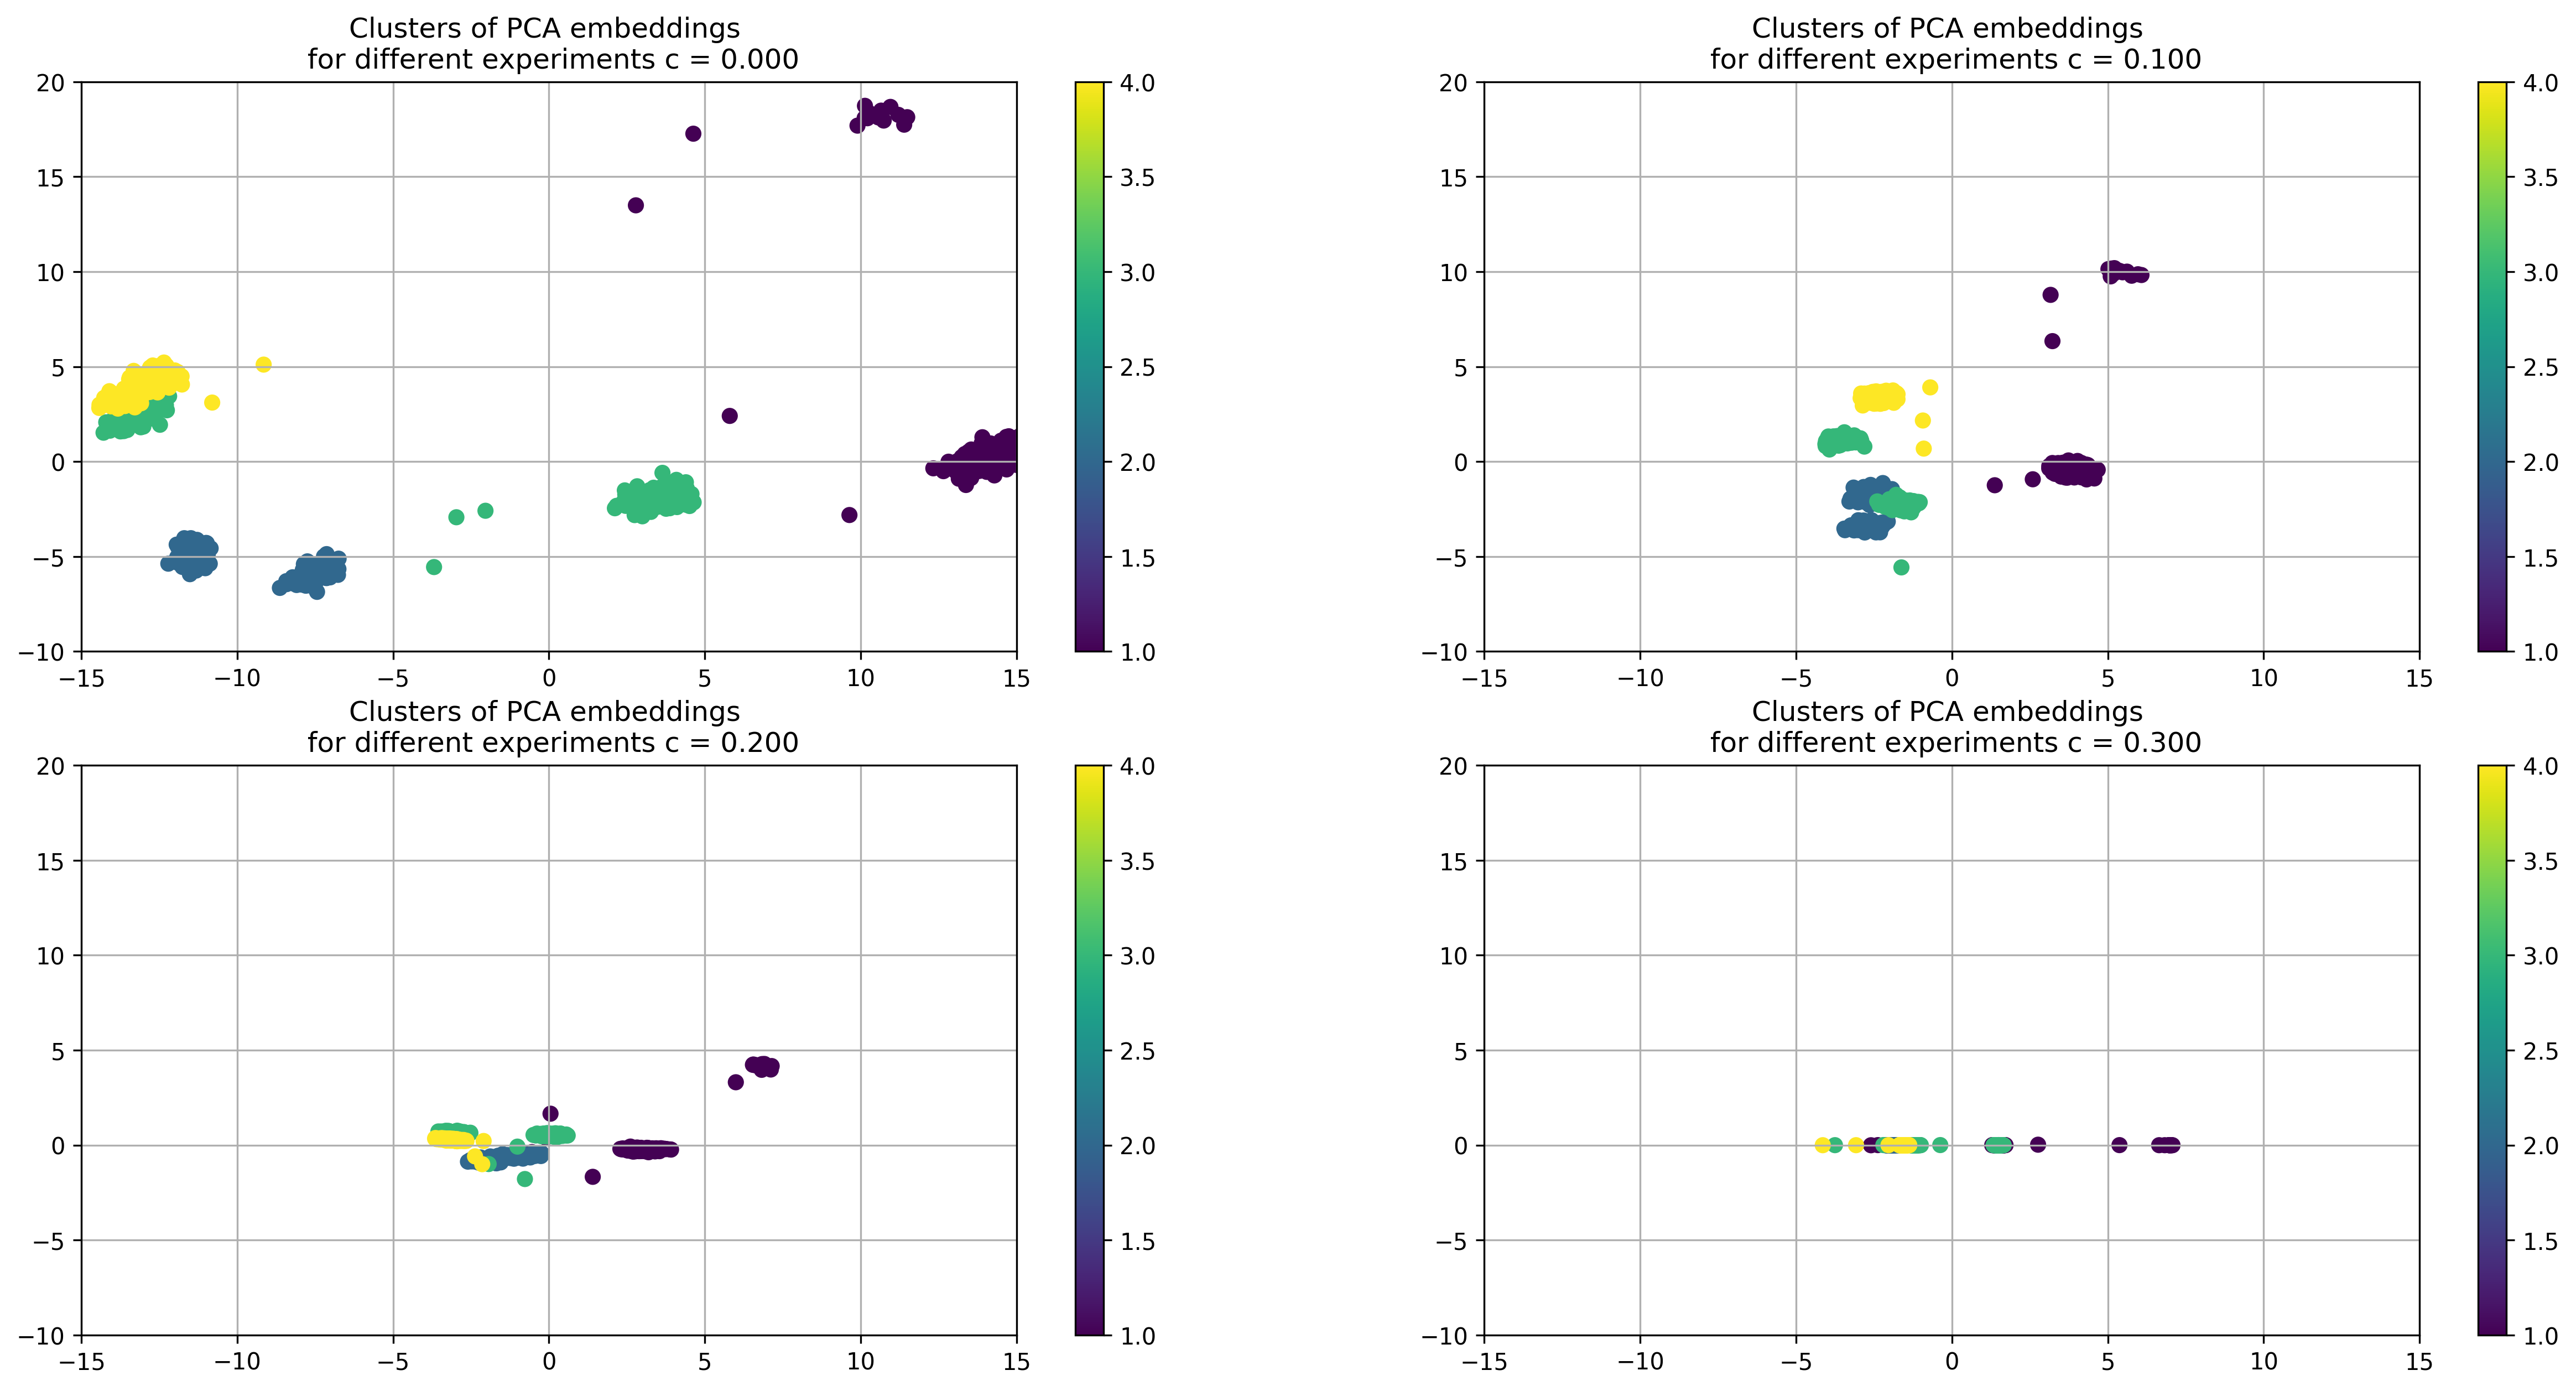

In [90]:
pplot.figure(figsize = (20,10), dpi = 300);

for kk,closs_ in enumerate([0, 0.1, 0.2, 0.3]):
    gen_adv_model.load_weights("model_closs%2.2f"%closs_)
    
    pplot.subplot(2,2,kk+1)
    pca_plot = plot_PCA(plot_directly = False, feature_extractor_model_= feature_extractor )

    pca_plot.on_epoch_end(epoch = 0)
    #pplot.grid()
    #pplot.title("With a c=0.05")
    pplot.colorbar()
    pplot.grid()
    pplot.xlim([-15,15])
    pplot.ylim([-10,20])
    
    pplot.title("Clusters of PCA embeddings \n for different experiments c = %2.3f"%closs_)
    

# *-*-*--**-*-*-*--*-*--*-*-*-8423542587f32ws84rf256s406f54s05e4rf05ws4erf25wse47rc25se4rc256s4erc25s4ercv0s5e4c0s5e4c













.










.
.










.
.










.
.










.
.










.
.










.




In [1]:
import tensorflow as tf
#tf.enable_eager_execution()
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as pplot
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, Flatten, BatchNormalization, Dropout
from sklearn.decomposition import PCA

import os

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)
tf.keras.backend.set_session(sess)
from tensorflow.math import confusion_matrix
from src.dilated_densenet_adversarial import make_model, make_densenet_parametrization_dictionary

In [6]:
%load_ext autoreload
%autoreload 
from src.util import plot_confusion_matrix
from src.experiments_utils import *

ndn = 5
ndn2 = 5

experiment_parametrization = {
    'dilation_rates_dn1': [2,4,8,16,32,64,128,512,8,16,32,64,128,512],#,4,8,16,32],
    'kernel_sizes_dn1' :  [10] * ndn,#,5,5],
    'nfilters_dn1' :  [20]*ndn,
    'dilation_rates_dn2' : [4]*ndn2,
    'kernel_sizes_dn2' : [5]*ndn2,
    'nfilters_dn2': [10]*ndn2
}

make_network_description_experiments_A(**experiment_parametrization)
model_json = make_network_json_experiments_A(**experiment_parametrization)

model_json["classifier"]["network_layers"][-1]['params']['units'] = 10
model_json["densenet_1d"]["network_layers"][0]["params"]["Variational"] = False
model_json["densenet_1d"]["network_layers"] = [
    model_json["densenet_1d"]["network_layers"][0],model_json["densenet_1d"]["network_layers"][-1]
]
model_json['inputs'][0]['shape'] = (1500,6)
model_json['domain_classifier']['network_layers'][-1]['params']['units'] = 4;

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:

# I need a couple of more stuff I need to reg. against
DA2_0 = np.max(X_all_0[:,:,1],-1)
DA3_0 = np.min(X_all_0[:,:,0],-1)
q0 = np.quantile(DA2_0,np.linspace(0,1,400))
q1=np.quantile(DA3_0,np.linspace(0,1,400))
#pplot.plot(q1,'.')
qs0 = [0.25,0.30,0.35,0.40,0.45,0.50]
qs1 = [-0.38,-0.35,-0.32,-0.28]

c0_0 = np.zeros_like(DA2_0);
c1_0 = np.zeros_like(DA3_0);
for qq0 in qs0:
    c0_0 = c0_0 +  (DA2_0<qq0) * 1
    
for qs1 in qs1:
    c1_0 = c1_0 +  (DA3_0<qs1) * 1
c0_0_oh = tf.one_hot(c0_0,np.unique(c0_0).shape[0]).eval()
c1_0_oh = tf.one_hot(c1_0,np.unique(c1_0).shape[0]).eval()

NameError: name 'X_all_0' is not defined

In [30]:
from sklearn.decomposition import PCA
#tf.keras.Sequential()
def make_models():
    model = make_model(model_json)
    feature_out_layer = model.get_layer([l.name for l in model.layers if "global_average" in l.name][0])
    feature_extractor  = Model(inputs = model.inputs,outputs =  feature_out_layer.output)
    grad_rev_layer = model.get_layer([l.name for l in model.layers if 'grad_rev' in l.name][0])
    c0_task_output = keras.Sequential([Dense(100, activation = 'relu'), Dropout(rate = 0.2), Dense(6)], name = "C0_task")(grad_rev_layer.output)
    c1_task_output = keras.Sequential([Dense(100,activation = 'relu'), Dropout(rate = 0.2), Dense(4)],name = "C1_task")(grad_rev_layer.output)
    gen_adv_model  = Model(inputs = model.input, outputs= [model.output, c0_task_output, c1_task_output])
    return gen_adv_model, feature_extractor,c0_task_output,c1_task_output

gen_adv_model, feature_extractor,c0_task_output,c1_task_output = make_models()

            

Tensor("DN_DN1_ConcatOut_3/concat:0", shape=(?, 1500, 320), dtype=float32)


In [11]:
from src.util import load_hilti_fatigue_data, digitize
def load_hilti_fatigue_data(keep_from_end = 150000,    n_cycles_per_sub_block = 5, n_resampled = 300,nclasses = 15, leave_exp_out = 'VA_2', stage_2_from_disk = False,user_normalization = None, use_ds = None):

    #keep_from_end = 150000;
    #nclasses = 15
    if use_ds is None:
        use_ds = [1,2,3,4]
    
    if stage_2_from_disk:
        #keep_from_end = 300000;

        for kk_ , ds_idx in enumerate(use_ds):
            print("proc:"+str(ds_idx))
            ds =pd.read_pickle("csv/subs_200k_200/subs_csvs/VA_test{}_stage_2.pickle".format(ds_idx))
            ds.reset_index(inplace = True)
            remc = (ds.Zyklen.max() - ds.Zyklen)

            ds = ds[remc<=keep_from_end]
            ds['RemCycles'] = remc
            ds['ExpId'] = "VA_%i"%ds_idx
            if kk_ == 0:
                dataset = ds
            else:
                dataset = pd.concat([dataset,ds])


        def make_block_id_column(x):
            block_id = np.cumsum(np.hstack([True,np.diff(x.Zyklen.values)>1]))
            x['BlockId'] = block_id
            return x

        #n_resampled = 300 # uniform re-sampling per cycle.

        d = dataset.groupby("ExpId").apply(make_block_id_column)
    else:
        d = pd.read_csv("csv/subs_200k_200/subs_dataframe_{}k_from_end".format(int(keep_from_end/1000)))

    ######################################################################################################
    #n_resampled = 300

    def make_data_per_block(x):
        # This loses some cycles from the end.
        # This function should not perform normalization because there will be information leakage.
        # The only exception are accelerations. There is a weird shift in the accelerations which 
        # could be from static electricity or sth. It was decided to remove it here (just mean centering 
        # - this should not cause information leakage).
        n_stop_idx = x.shape[0] - (x.shape[0] % (n_resampled*n_cycles_per_sub_block))
        x = x[0:n_stop_idx]

        n_cycles_in_block = int(x.shape[0]/ n_resampled)
        shape_ = [n_cycles_in_block,int(x.shape[0]/n_cycles_in_block)]

        tangent_stiffness = x['KraftQ']/(x['WegQ']**0.15+ 0.1)
        tangent_stiffness = tangent_stiffness.values.reshape(shape_)
        f = x['KraftQ'].values.reshape(shape_)
        u = x['WegQ'].values.reshape(shape_)
        kdot = x['Kdot'].values.reshape(shape_)
        accel = x['AccelQ'].values.reshape(shape_)
        wdot = x['Wdot'].values.reshape(shape_)
        accel = accel - np.mean(accel)
        vals_dat = np.dstack([tangent_stiffness, f, u, accel, kdot, wdot])
        vals_dat = vals_dat.reshape([-1,n_cycles_per_sub_block*n_resampled,vals_dat.shape[-1]])

        get_scalar = lambda scname, x : x[scname].values.reshape(shape_).reshape([-1,n_cycles_per_sub_block*300])[:,0]

        rem_c_dat = get_scalar('RemCycles', x)
        #rem_c_dat = rem_c_dat.reshape([-1, n_cycles_per_sub_block])

        eid = get_scalar('ExpId',x)

        return vals_dat, rem_c_dat, eid

    training_data = d.groupby(["ExpId","BlockId"]).apply(make_data_per_block)


    X = np.vstack([v[0] for v in training_data.values])
    RemC = np.concatenate([v[1] for v in training_data.values])
    Eid = np.concatenate([v[2] for v in training_data.values])
    Yoh = digitize(RemC, -1, np.max(RemC)+1, nclasses)


    d.drop(axis = 1 , labels = [c for c in d.columns if 'Unnamed' in c], inplace = True)
    d.drop(axis = 1 , labels = [c for c in d.columns if 'level' in c], inplace = True)
    mean_disp = d.groupby(["ExpId",'BlockId']).apply(lambda x : x['WegQ'].max())
    w_exp_means = mean_disp.reset_index().groupby("ExpId").apply(lambda x : x.quantile(0.10))
    eids = ['VA_%i'%i for i in use_ds]
    for ee in eids:
        X[Eid == ee, :, 2] = X[Eid == ee,:,2] - w_exp_means.loc[ee].values[1]

    ## Filtering manually some outliers. This was based on manual inspection up to 100k cycles from end.
    f1 = np.min(X[:,:,0],1)>0.1
    f2 = np.max(np.abs(X[:,:,3]),1)<2
    f3 = np.max(X[:,:,4],1) < 1000
    f4 = np.max(np.abs(X[:,:,5]),1)<50
    ftot = f1 * f2 * f3 *f4



    X_clean = X[ftot,:,:]
    Y_clean = RemC[ftot]
    Eid_clean = Eid[ftot]
    Yoh_clean = Yoh[ftot]

    ts_sub    = np.mean(X_clean[:,:,0])
    ts_divide = np.max(X_clean[:,:,0])

    f_sub    = np.mean(X_clean[:,:,1])
    f_divide = np.max(X_clean[:,:,1])

    u_sub    = np.mean(X_clean[:,:,2])
    u_divide = np.max(X_clean[:,:,2])

    accel_sub =  np.mean(X_clean[:,:,3])
    accel_divide =  np.std(X_clean[:,:,3])

    kdot_sub = np.mean(X_clean[:,:,4])
    kdot_divide = np.std(X_clean[:,:,4])

    wd_sub = np.mean(X_clean[:,:,5])
    wd_divide = np.std(X_clean[:,:,5])


    normalization = np.array([[ts_sub, ts_divide],
                              [f_sub, f_divide],
                              [u_sub, u_divide],
                              [accel_sub, accel_divide],
                             [kdot_sub, kdot_divide],
                             [wd_sub, wd_divide]]).astype("float32")

    del d
    if user_normalization is not None:
        normalization = user_normalization

    Xnorm = (X_clean.astype("float32") - normalization[:,0])
    Xnorm = Xnorm/ normalization[:,1]

    eid_vector = Eid_clean


    Xstrong, Ystrong, YstrongOH, eid_vector_strong = [Q[Eid_clean == leave_exp_out] for Q in [Xnorm,Y_clean,Yoh_clean,eid_vector]]
    X, Y,Yoh, eid_vector = [Q[Eid_clean !=  leave_exp_out] for Q in [Xnorm,Y_clean,Yoh_clean,eid_vector]]

    return {"training_instances" : [X, Y, Yoh, eid_vector] , "validation_instances" : [Xstrong, Ystrong, YstrongOH, eid_vector_strong], "normalization" : normalization, "nclasses" : nclasses}


In [12]:
del X_all_0
del Xtrain
del Xtest

NameError: name 'X_all_0' is not defined

In [25]:
import pandas as pd
data = load_hilti_fatigue_data(keep_from_end = 100000,leave_exp_out="None",stage_2_from_disk=True, nclasses = 10, user_normalization=None, use_ds = [1,2,3,4])
static_normalization = data['normalization']


proc:1
proc:2
proc:3
proc:4


In [26]:

data = load_hilti_fatigue_data(keep_from_end = 200000,leave_exp_out="None",stage_2_from_disk=True, nclasses = 10, user_normalization=static_normalization, use_ds = [1,2,3,4])

proc:1
proc:2
proc:3
proc:4


In [27]:
import pandas as pd

In [28]:
[X_all_,Y_all_,Yoh_all_, eid_vector_all_] = data['training_instances']
eid_vector_all_

array(['VA_1', 'VA_1', 'VA_1', ..., 'VA_4', 'VA_4', 'VA_4'], dtype=object)

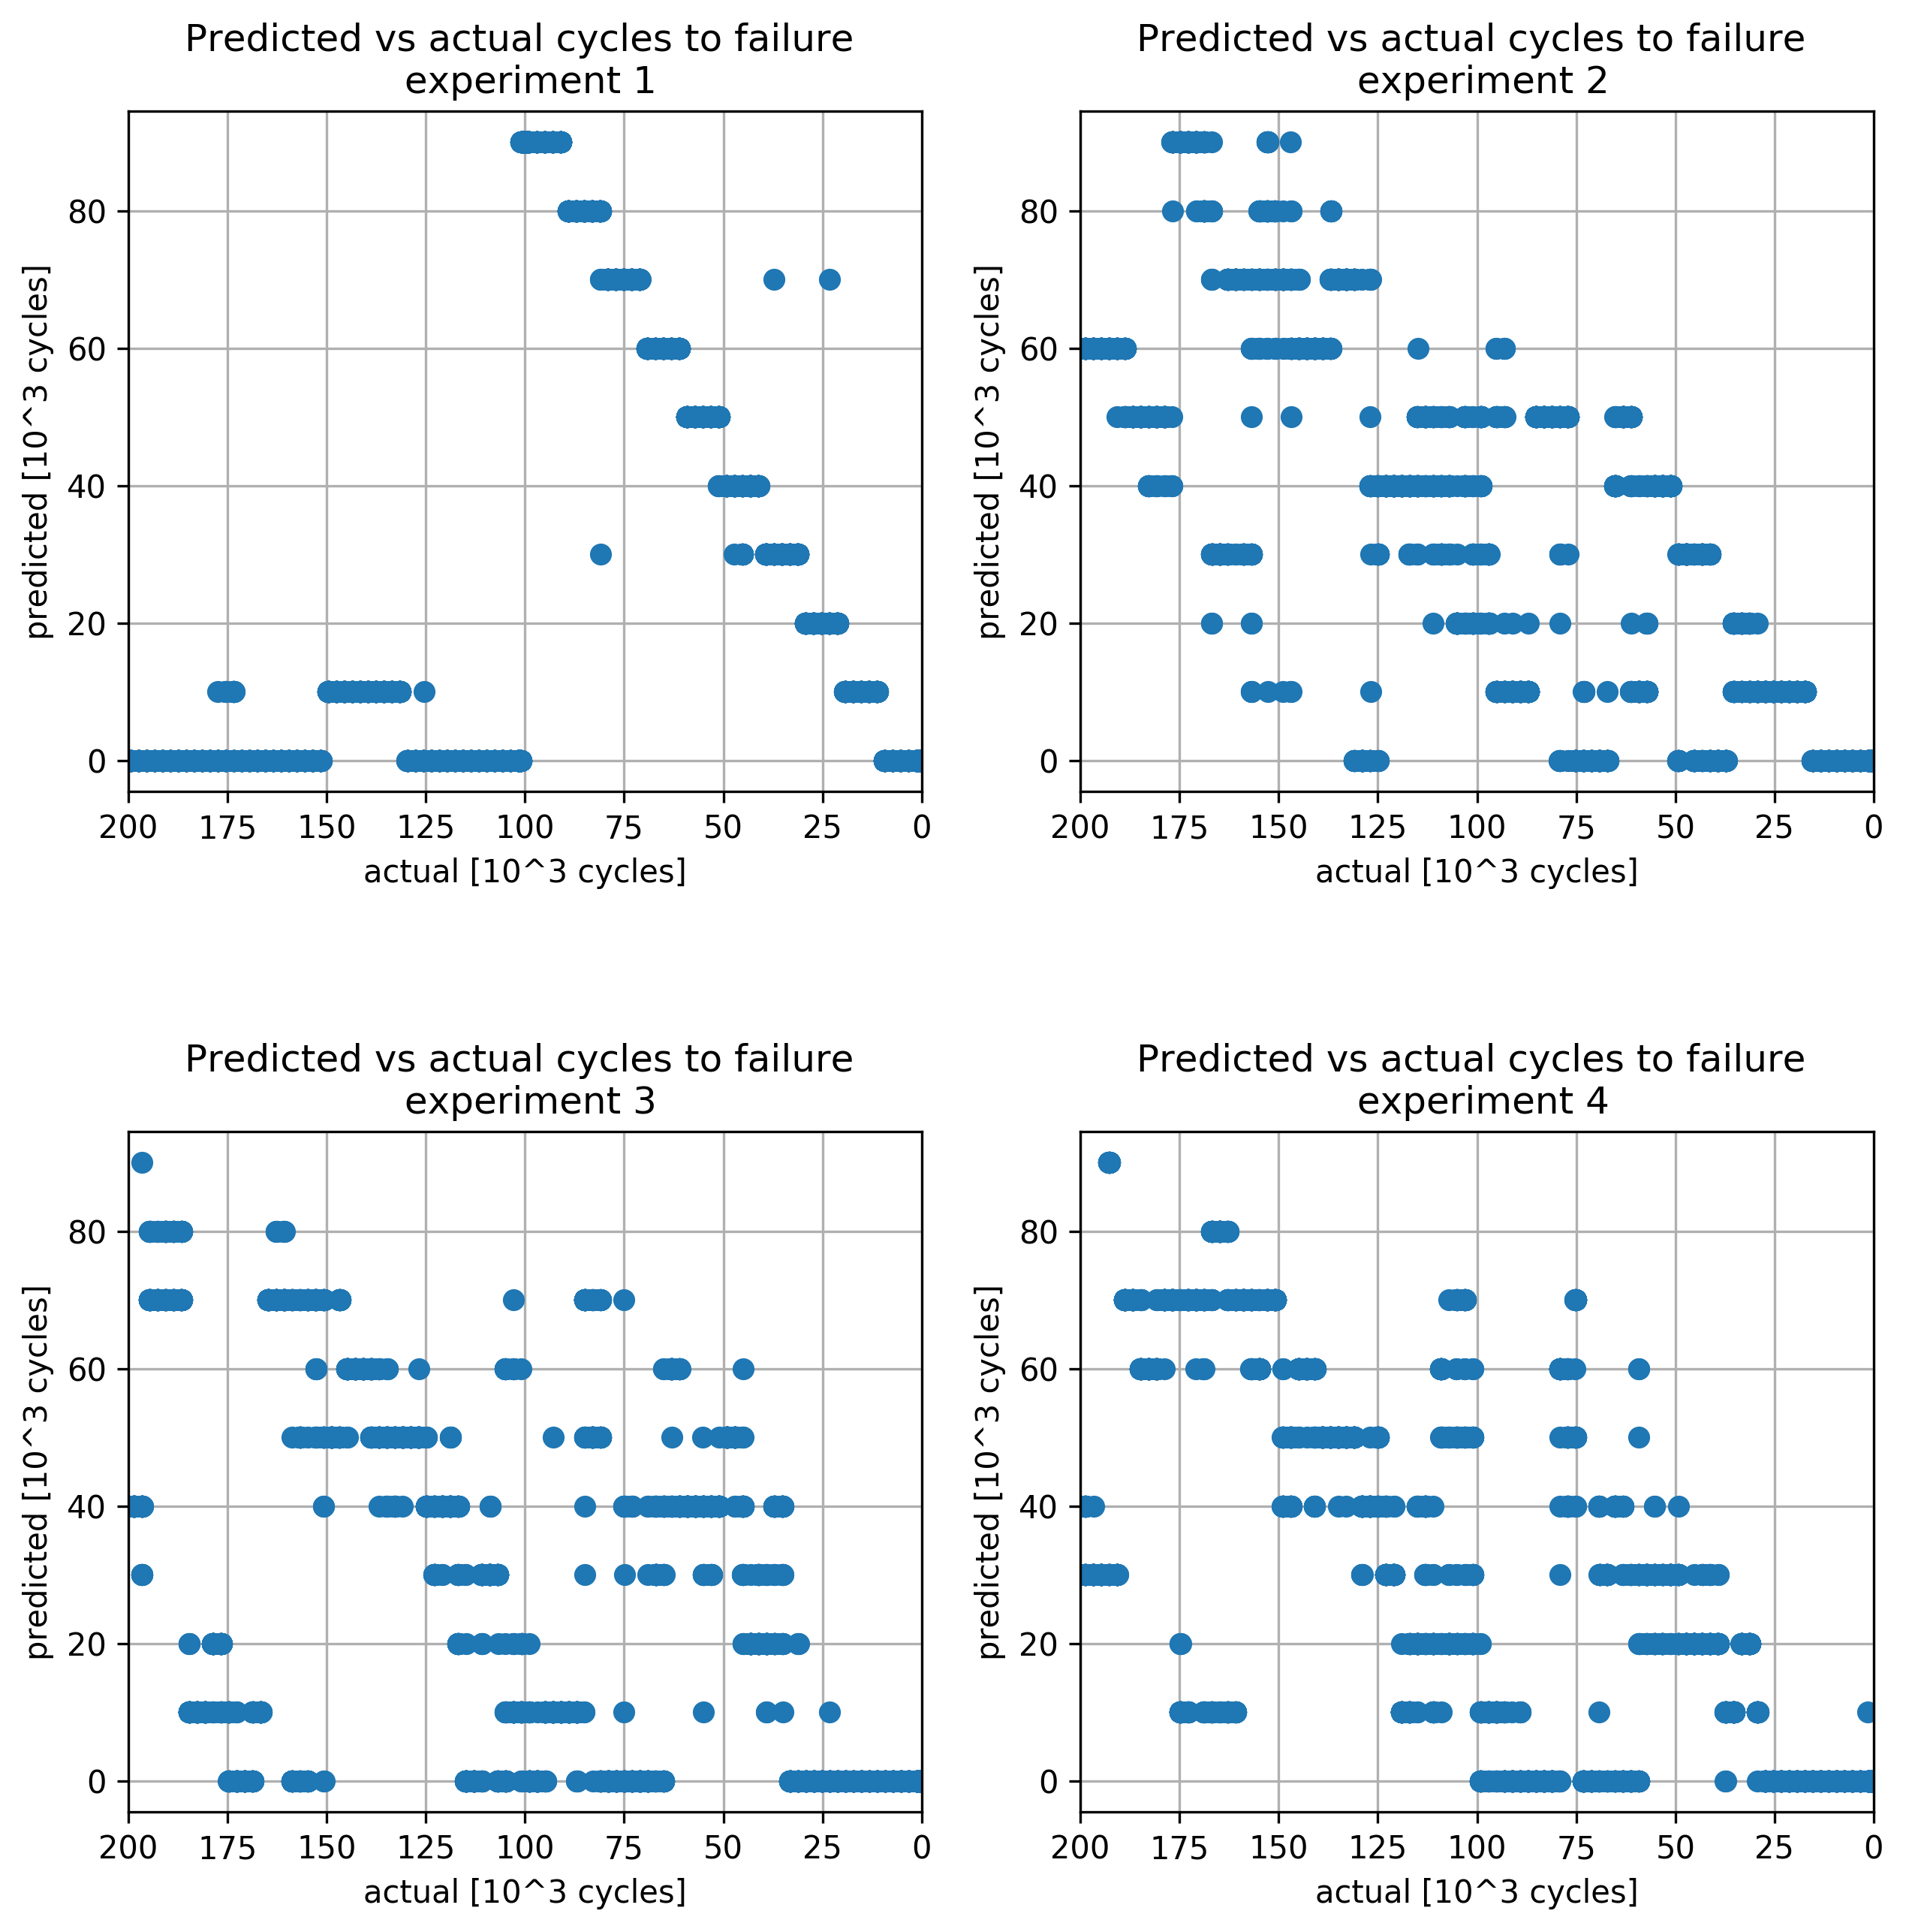

In [35]:
pplot.figure(figsize = (10,10), dpi = 300)
gen_adv_model.load_weights("model_closs%2.2f"%0.0)
for i in range(1,5):
    #data = load_hilti_fatigue_data(keep_from_end = 100000,leave_exp_out="None",stage_2_from_disk=True, nclasses = 10, user_normalization=static_normalization, use_ds = [i])
    #[X_all_,Y_all_,Yoh_all_, eid_vector_all_] = data['training_instances']
    yplot = Y_all_[eid_vector_all_ == 'VA_%i'%i]
    xdat  = X_all_[eid_vector_all_ == 'VA_%i'%i]
    res = gen_adv_model.predict(xdat, batch_size = 200)
    pplot.subplot(2,2,i)
    
    pplot.plot(yplot/1000,np.argmax(res[1],1)*10,'o');
    pplot.xlim([200,0])
    pplot.xlabel("actual [10^3 cycles]")
    pplot.ylabel("predicted [10^3 cycles]")
    #pplot.ylim([0,300000])
    pplot.title("Predicted vs actual cycles to failure \n experiment %i"%i);
    pplot.grid()
pplot.subplots_adjust(hspace=0.5)

In [81]:
#pplot.plot(Y_all_,np.argmax(res[1],1))


(6257, 10)

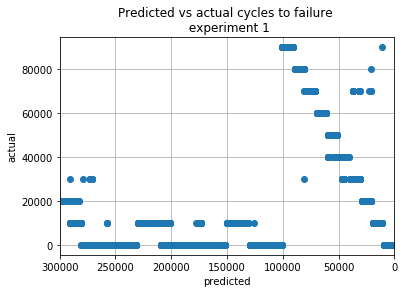

In [ ]:
tc = Top3AccStrong()#
tc.on_epoch_end(epoch = 0)


In [54]:
gen_adv_model.loss_weights['ExpID'].assign(0.2)
with keras.backend.get_session():
    gen_adv_model.loss_weights['ExpID'].assign(0.2)
    gen_adv_model.loss_weights['ExpID'].eval(session=keras.backend.get_session())


AttributeError: 'float' object has no attribute 'assign'

In [55]:
help(gen_adv_model.loss_weights['ExpID'].assign)

AttributeError: 'float' object has no attribute 'assign'

In [56]:
gen_adv_model._training_endpoints[0].loss_weight = 

SyntaxError: invalid syntax (<ipython-input-56-0858bdc05180>, line 1)

In [37]:
gen_adv_model.loss_weights

{'Y_output': 1,
 'ExpID': <tf.Variable 'Variable:0' shape=() dtype=float32>,
 'C0_task': <tf.Variable 'Variable:0' shape=() dtype=float32>,
 'C1_task': <tf.Variable 'Variable:0' shape=() dtype=float32>}

In [235]:
inspect_model = keras.Model(inputs = model.layers[0].input,outputs = model.get_layer("DN_DN1_Out").output)


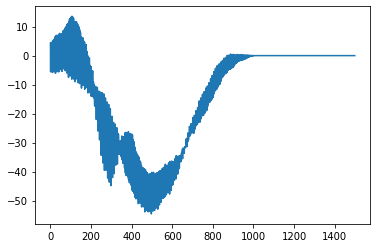

In [329]:
xx = Xtrain[0];
d1 = xx;#[np.newaxis]
dshift = np.zeros_like(d1)
pshift = 750
chan = 5;

dshift[0:pshift,chan] = np.random.randn(*dshift[0:pshift,chan].shape)*10
dshift.shape, d1.shape
v1 = (d1 + dshift)[np.newaxis]
v2 = d1[np.newaxis]
#d1_2 = d1 + np.hstack(np.random.randn()
n1 = (inspect_model(v1)[0,:,0].eval())
n2 = (inspect_model(v2)[0,:,0].eval())
pplot.plot(n1 - n2)
#pplot.plot(n2)


In [59]:

i1 = (Y_all_0 < 100000) * (Y_all_0 > 90000)
i2 = (Y_all_0 < 90000) * (Y_all_0 > 80000)
i3 = (Y_all_0 < 80000) * (Y_all_0 > 70000)
i4 = (Y_all_0 < 70000) * (Y_all_0 > 60000)
i5 = (Y_all_0 < 60000) * (Y_all_0 > 50000)
i6 = (Y_all_0 < 50000) * (Y_all_0 > 40000)

#i4 = (Y_all_0 < 70000) * (Y_all_0 > 60000)

ranges = [i1,i2,i3,i4,i5,i6]
vv = [];
eid_curr= [];
rcyc = [];
for k,ii_ in enumerate(ranges):
    #eevs = [  for ii_ in ranges]
    vv.append((np.mean(inspect_model.predict(X_all_0[ii_], batch_size = 100),1)))#, label = "range %i"%k)
    eid_curr.append( eid_vector_all_0[ii_])
    rcyc.append(Y_all_0[ii_])


In [60]:
def to_integer_vector(cat_vector):
    levels = np.unique(cat_vector)
    res = np.zeros_like(cat_vector)
    for kk,ll in enumerate(levels):
        
        res[cat_vector==ll] = kk
    return res



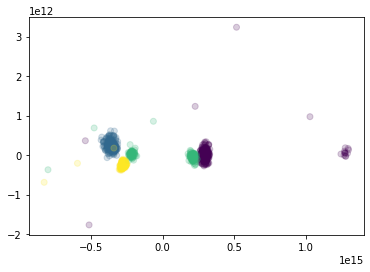

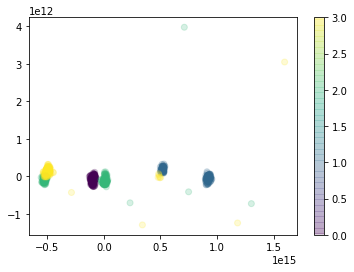

In [61]:
ranges_flat = np.hstack(ranges)
vv_ = np.vstack(vv)
vv_ = vv_ - np.mean(vv_)
vv_ = vv_.T / np.std(vv_,1)
#pplot.pcolor(vv_)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)


range_val = 0;
p = pca.fit_transform(vv[range_val])
pplot.scatter(p[:,0],p[:,1], c = to_integer_vector(eid_curr[range_val]), alpha = 0.2)
pplot.show()
range_val = 2;
p = pca.fit_transform(vv[range_val])

pplot.scatter(p[:,0],p[:,1], c = to_integer_vector(eid_curr[range_val]), alpha = 0.2)
pplot.colorbar()

In [308]:

#eid_curr[0].shape

### Estimation of remaining cycles - consequtive blocks


In [311]:
## load the larger stage-2 dataset.
#del data
#data_orig = load_hilti_fatigue_data(keep_from_end=  300000,leave_exp_out="None",stage_2_from_disk=False, nclasses = 30, user_normalization = static_normalization)
#data = load_hilti_fatigue_data(keep_from_end=  300000,leave_exp_out="None",stage_2_from_disk=True, nclasses = 30)


In [312]:
#[X_all_large,Y_all_large,Yoh_all_large, eid_vector_all_large] = data_orig['training_instances']
[X_all_large,Y_all_large,Yoh_all_large, eid_vector_all_large] = [X_all_0,Y_all_0,Yoh_all_0, eid_vector_all_0] 


## Inspection of the evolution of the predictions
* The following are not confusion matrices. They are softmax scores for consecutive predictions. The bottom right block are the cycles closer to failure that are sampled with a higher resolution for all experiments.
* For the held-out experiment a trend towards failure for subsequent cycles in indeed followed. 
* For almost all samples less than 10k cycles from failure the prediction is very accurate (in the final stage of fatigue). 

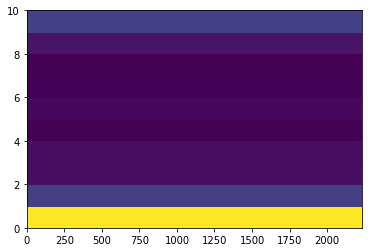

In [93]:
#pplot.plot(Y_all_large)
Xp  = X_all[eid_vector_all=='VA_3']
Yp = Y_all[eid_vector_all=='VA_3']
preds = gen_adv_model.predict(Xp, batch_size=100)
pplot.pcolor(tf.math.softmax(preds[1],axis = 1).eval().T)
pplot.show()


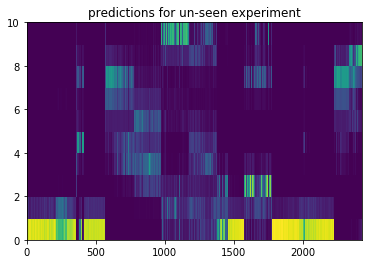

In [331]:
Xp  = X_all[eid_vector_all=='VA_1']
Yp = Y_all[eid_vector_all=='VA_1']
preds = model.predict(Xp, batch_size=100)
pplot.pcolor(tf.math.softmax(preds[1],axis = 1).eval().T)
pplot.title("predictions for un-seen experiment")
pplot.show()


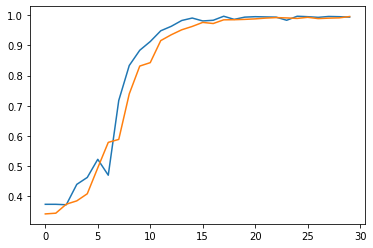

In [315]:
pplot.plot(history_d.history['val_Y_output_top3_acc'])
pplot.plot(history_d.history['Y_output_top3_acc'])

In [316]:

ii = inspect_model.predict(X_all[eid_vector_all == 'VA_3'][::10,:,:], batch_size=100)[:,::10,:]
ii2 = inspect_model.predict(X_all[eid_vector_all == 'VA_1'][::10,:,:], batch_size=100)[:,::10,:]
#ii2 = inspect_model.predict(X_all[eid_vector_all == 'VA_1'], batch_size=100)


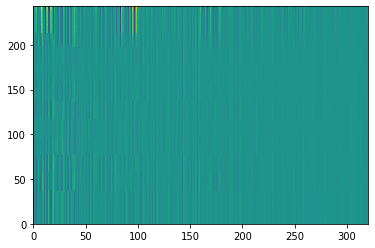

In [321]:
pplot.pcolor(np.mean(ii2,1))

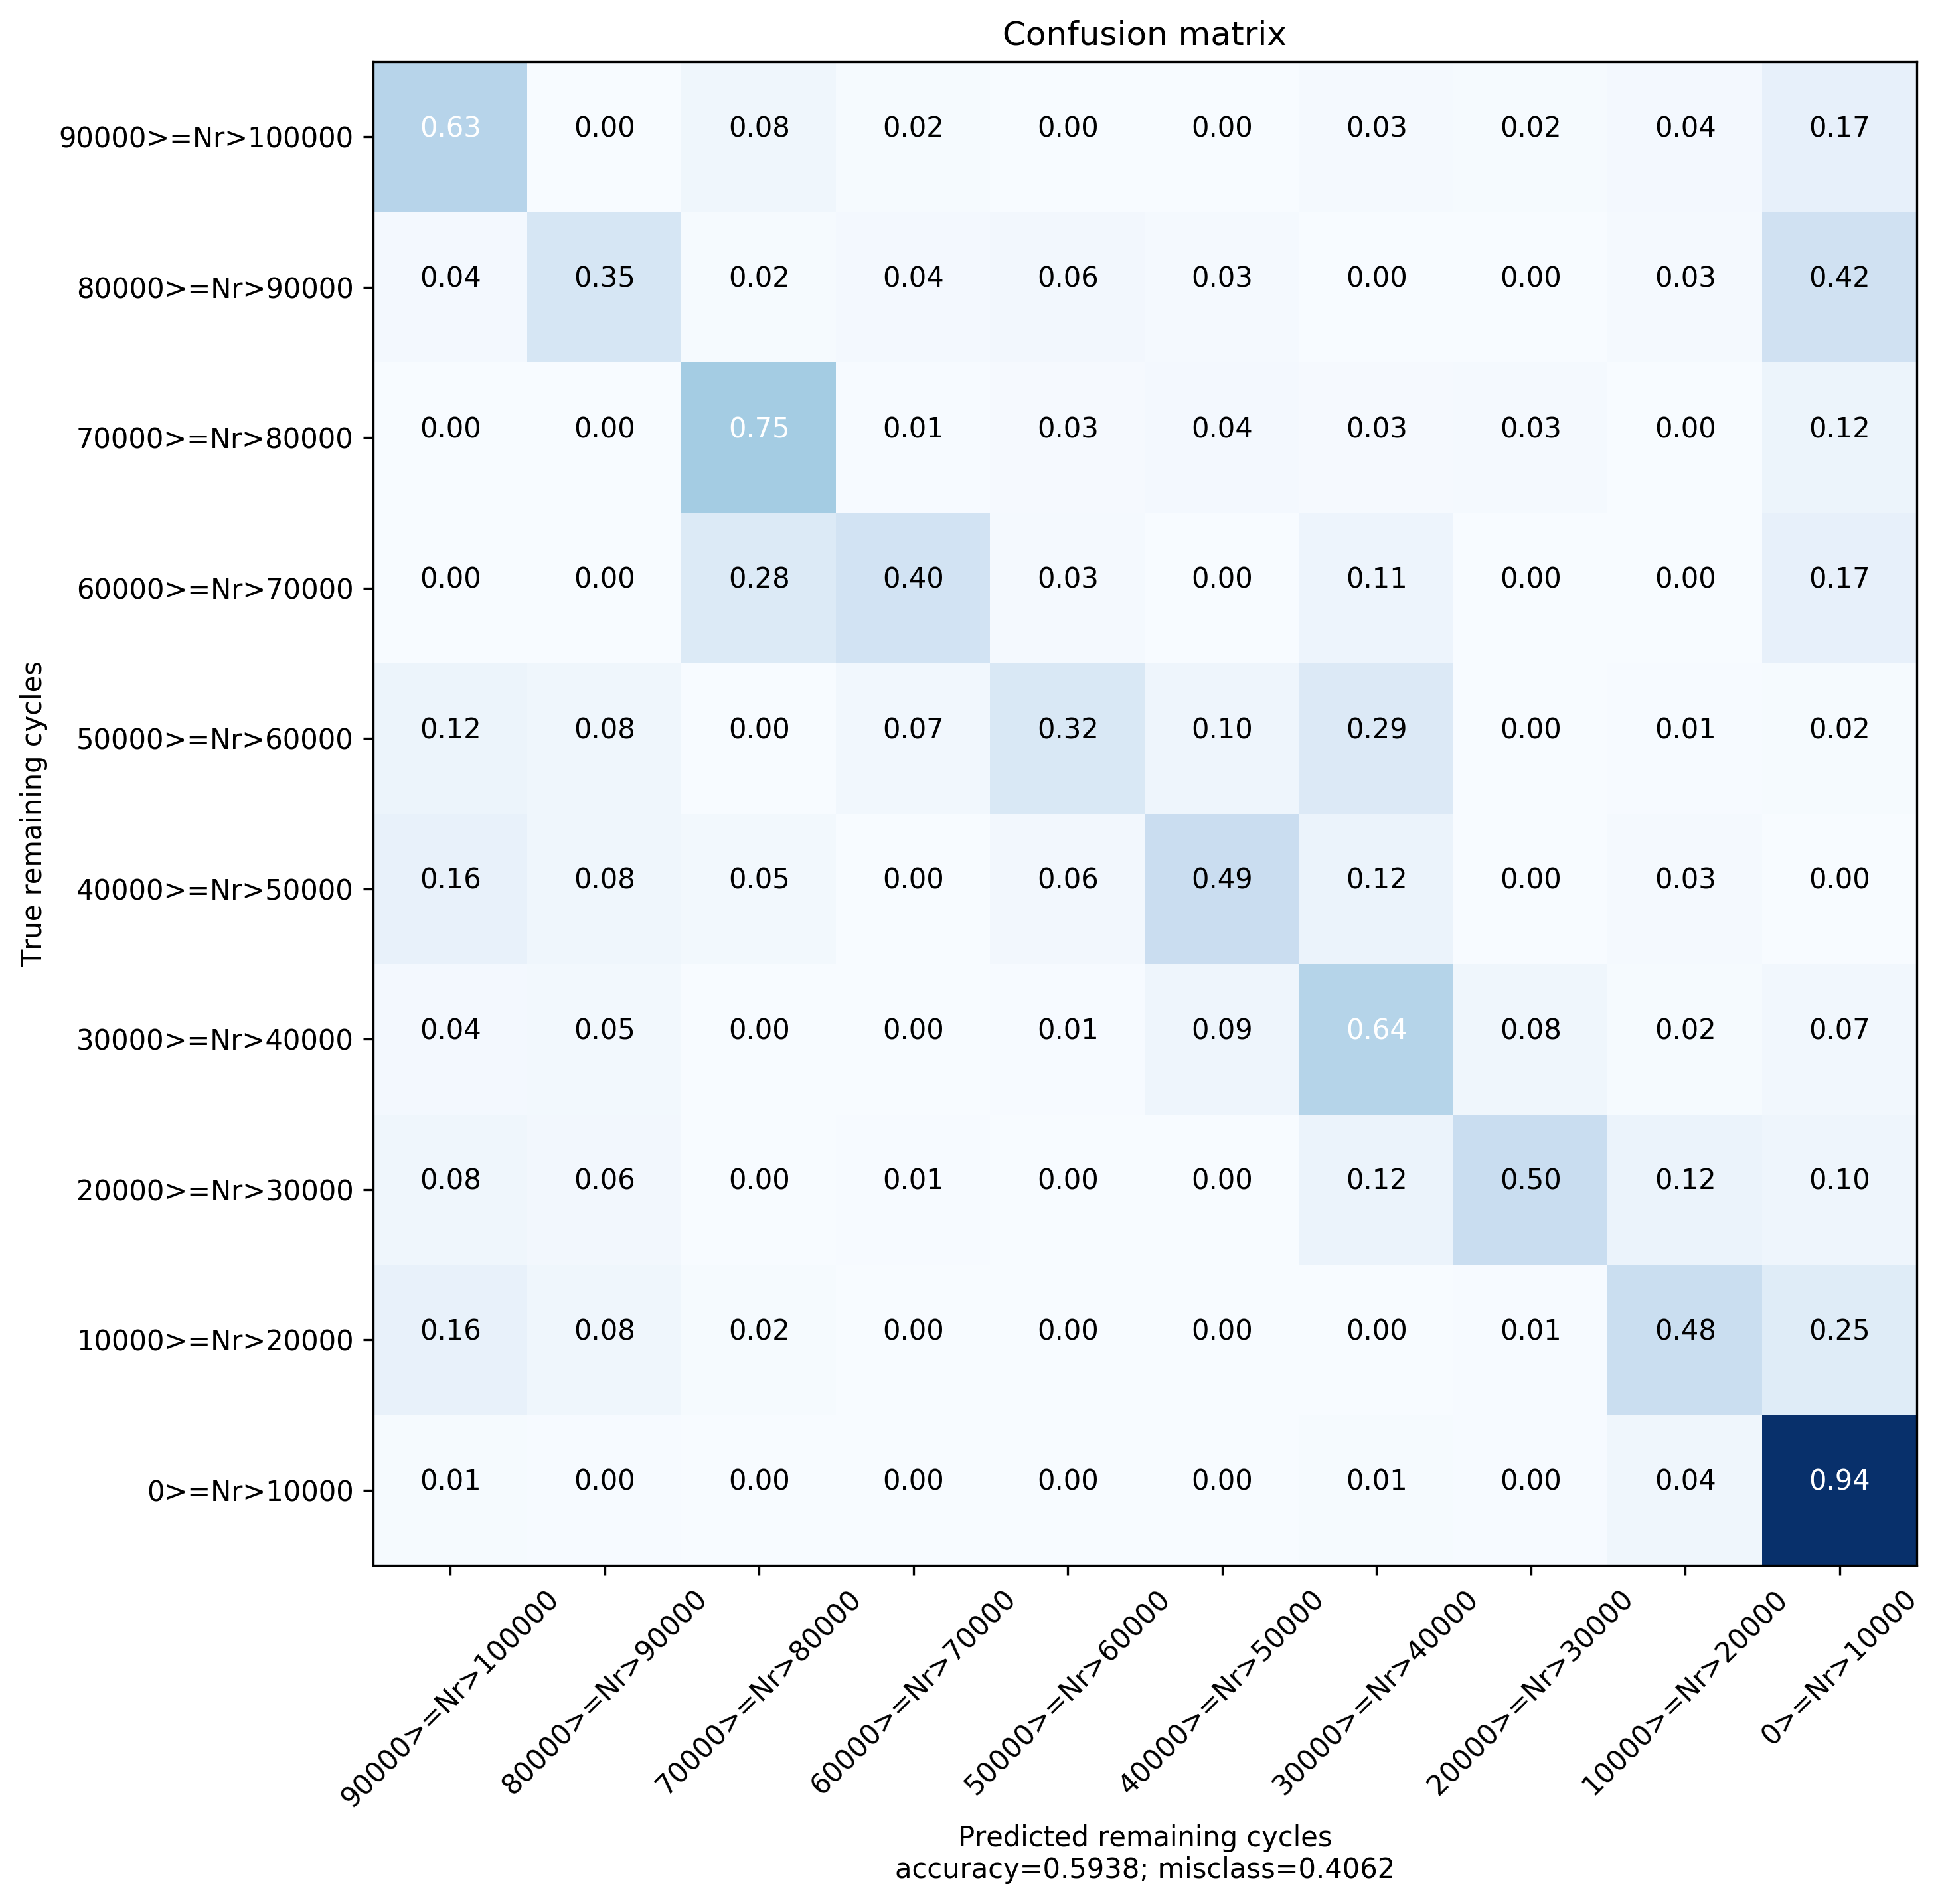

In [332]:
yhat = model.predict(Xtest, batch_size=100)[1]
crange = 10000
if tf.executing_eagerly():
    cmat = tf.confusion_matrix(tf.argmax(Ytest,1), tf.argmax(yhat,1)).numpy()
else:
    cmat = tf.confusion_matrix(tf.argmax(Ytest,1), tf.argmax(yhat,1)).eval(session = tf.keras.backend.get_session())
target_names = ["%i>=Nr>%i"%((i)*crange,(i+1)*crange) for i in range(int(cmat.shape[0]))]
plot_confusion_matrix(cmat, target_names = target_names, normalize=True)

In [227]:

#model.save("trained_model_VA2/model_")
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timeseries_input (InputLayer)   [(None, 1500, 6)]    0                                            
__________________________________________________________________________________________________
DN_DN1_C1D (Conv1D)             (None, 1500, 20)     140         timeseries_input[0][0]           
__________________________________________________________________________________________________
DN_DN1_idx_0 (Sequential)       (None, 1500, 20)     4440        DN_DN1_C1D[0][0]                 
__________________________________________________________________________________________________
DN_DN1_idx_1 (Sequential)       (None, 1500, 20)     4440        DN_DN1_idx_0[0][0]               
                                                                 DN_DN1_C1D[0][0]          

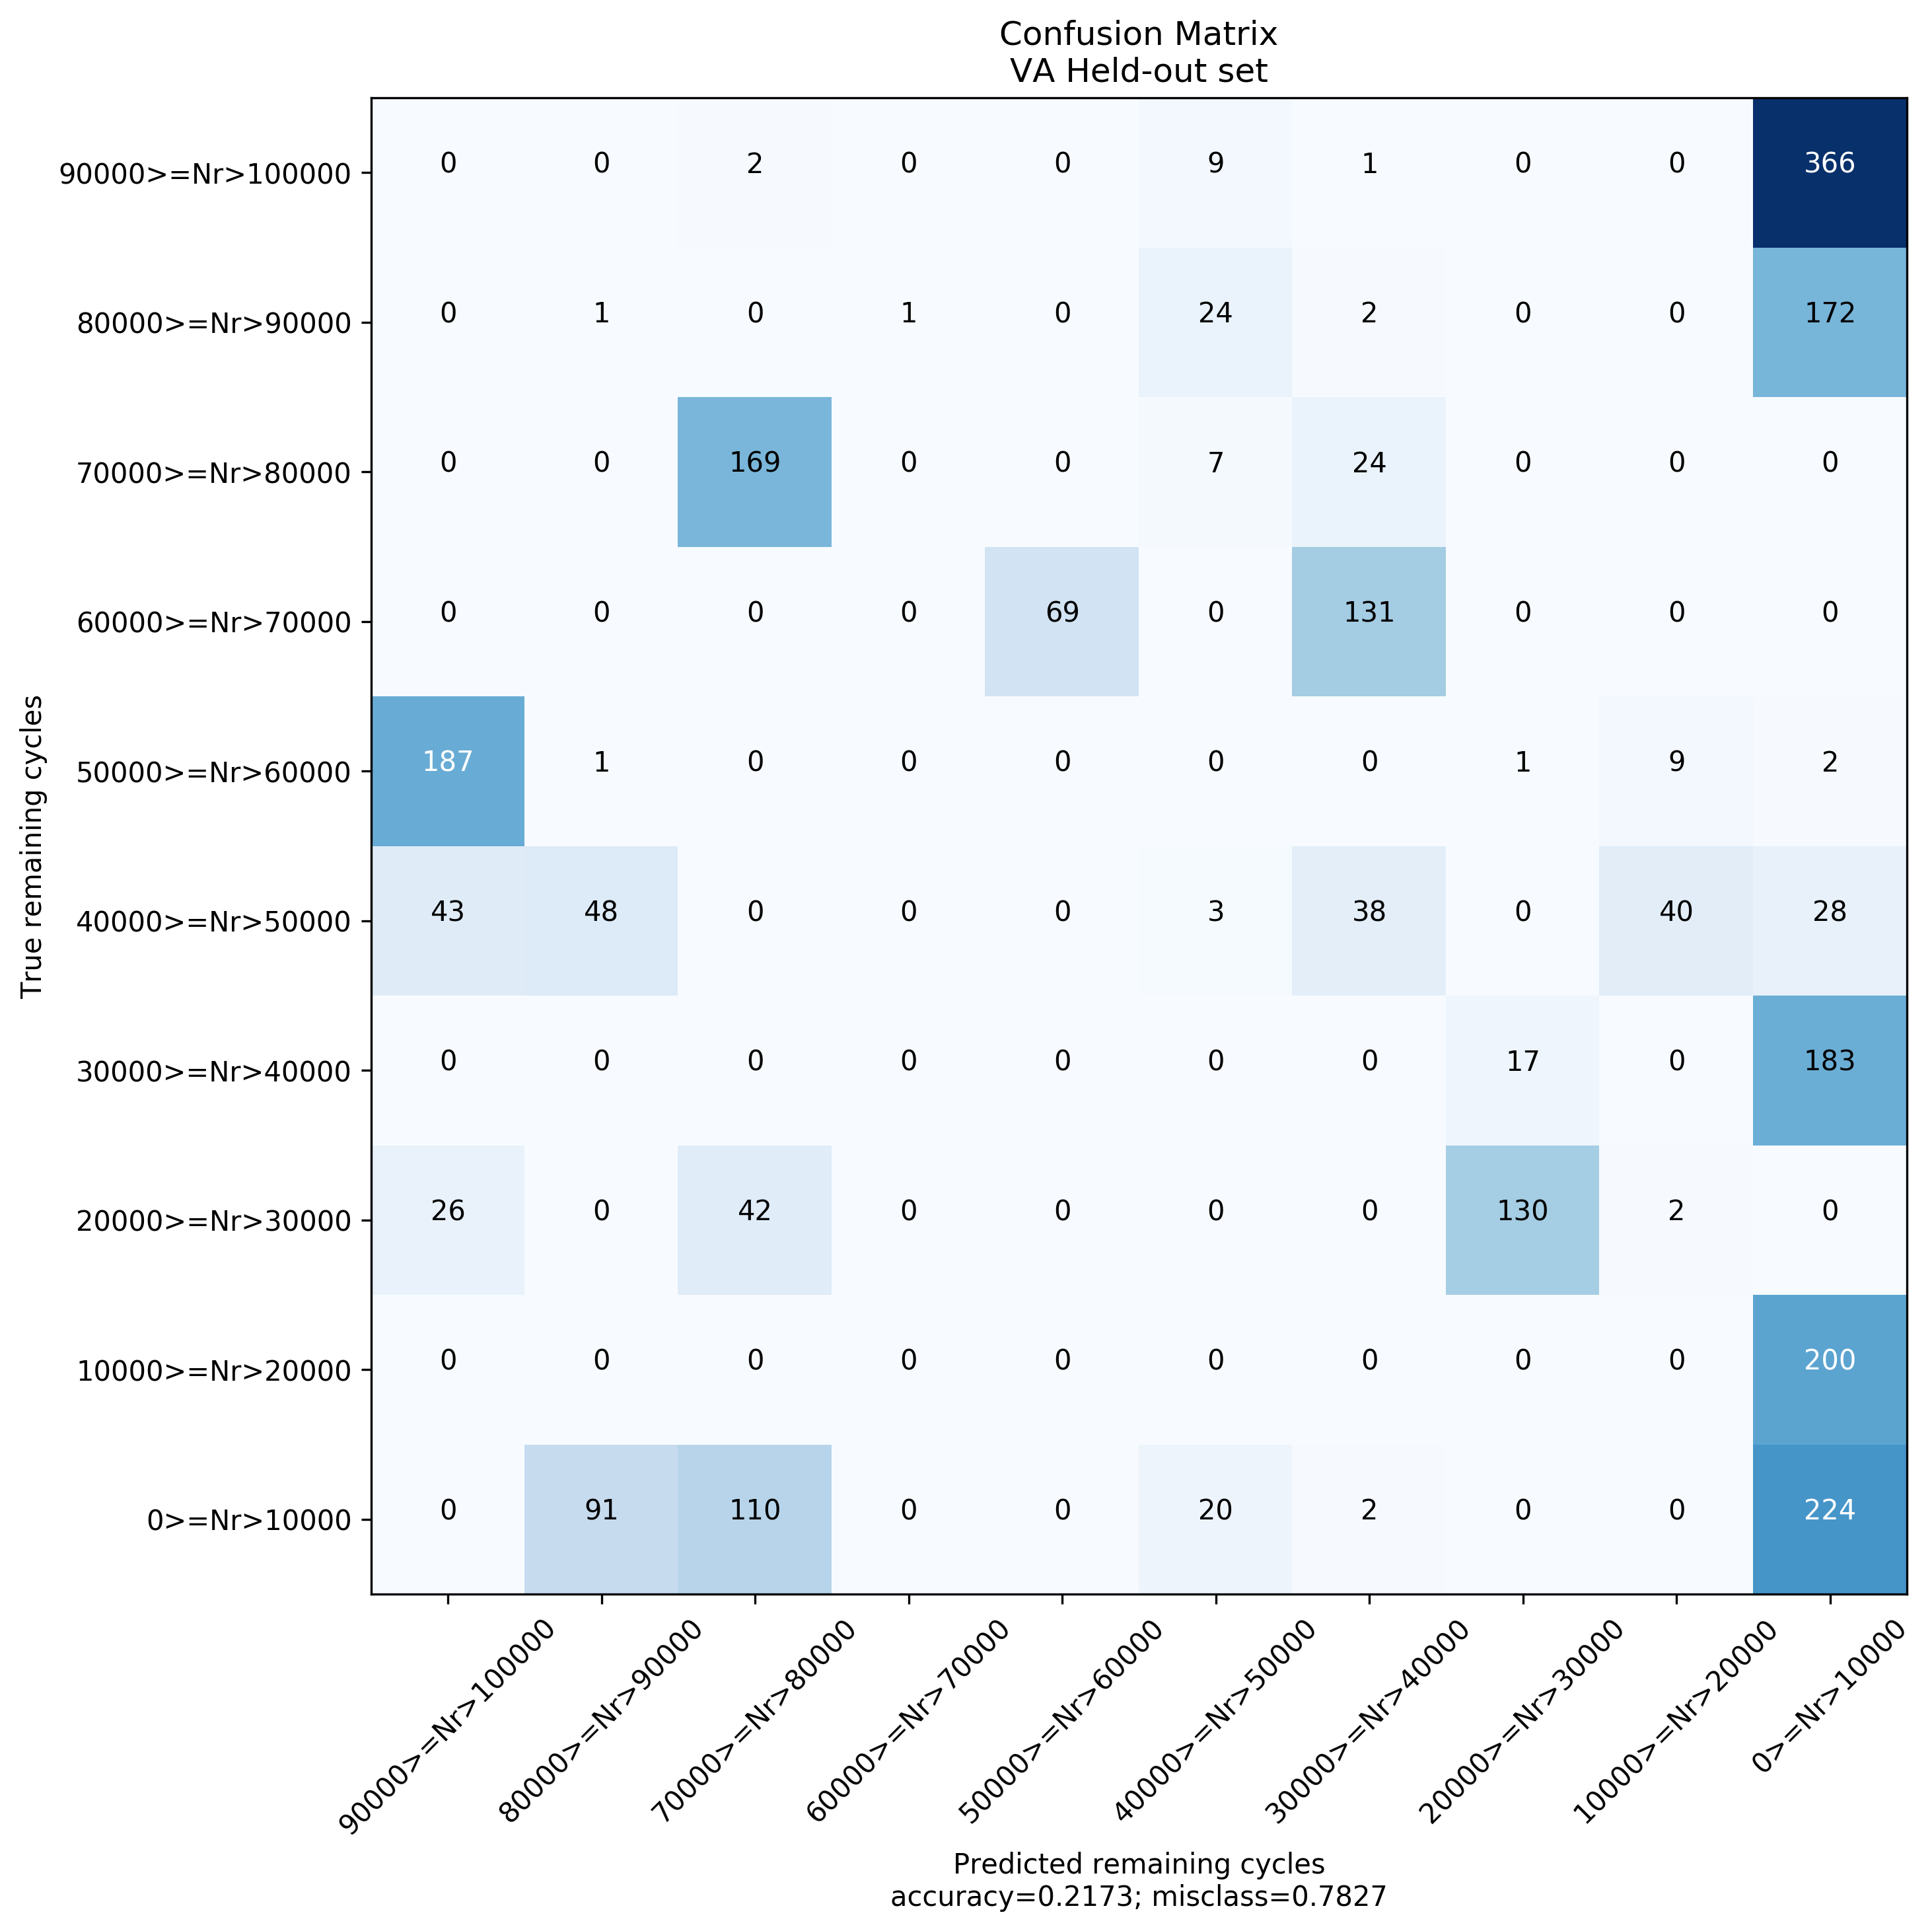

In [333]:
yyhat = model.predict(Xstrong)
cmat = confusion_matrix(np.argmax(YstrongOH,1),np.argmax(yyhat[1],1))
#cmat = cmat[0:-1,0:-1]
crange = int(150000/15);
target_names = ["%i>=Nr>%i"%((i)*crange,(i+1)*crange) for i in range(cmat.shape[0])]
plot_confusion_matrix(cmat.eval(session = keras.backend.get_session()),
                      target_names = target_names , figsize = (10,10), normalize= False, title = "Confusion Matrix\nVA Held-out set")
